# Content:
1. Classification using Deep Neural Network
2. Recurrent Neural Networks for Language Modeling
3. Gated Recurrent Units (GRU)
4. Deep and Bi-directional RNNs
3. LSTMs and Named Entity Recognition
4. Siamese Networks

# Classification using Deep Neural Network

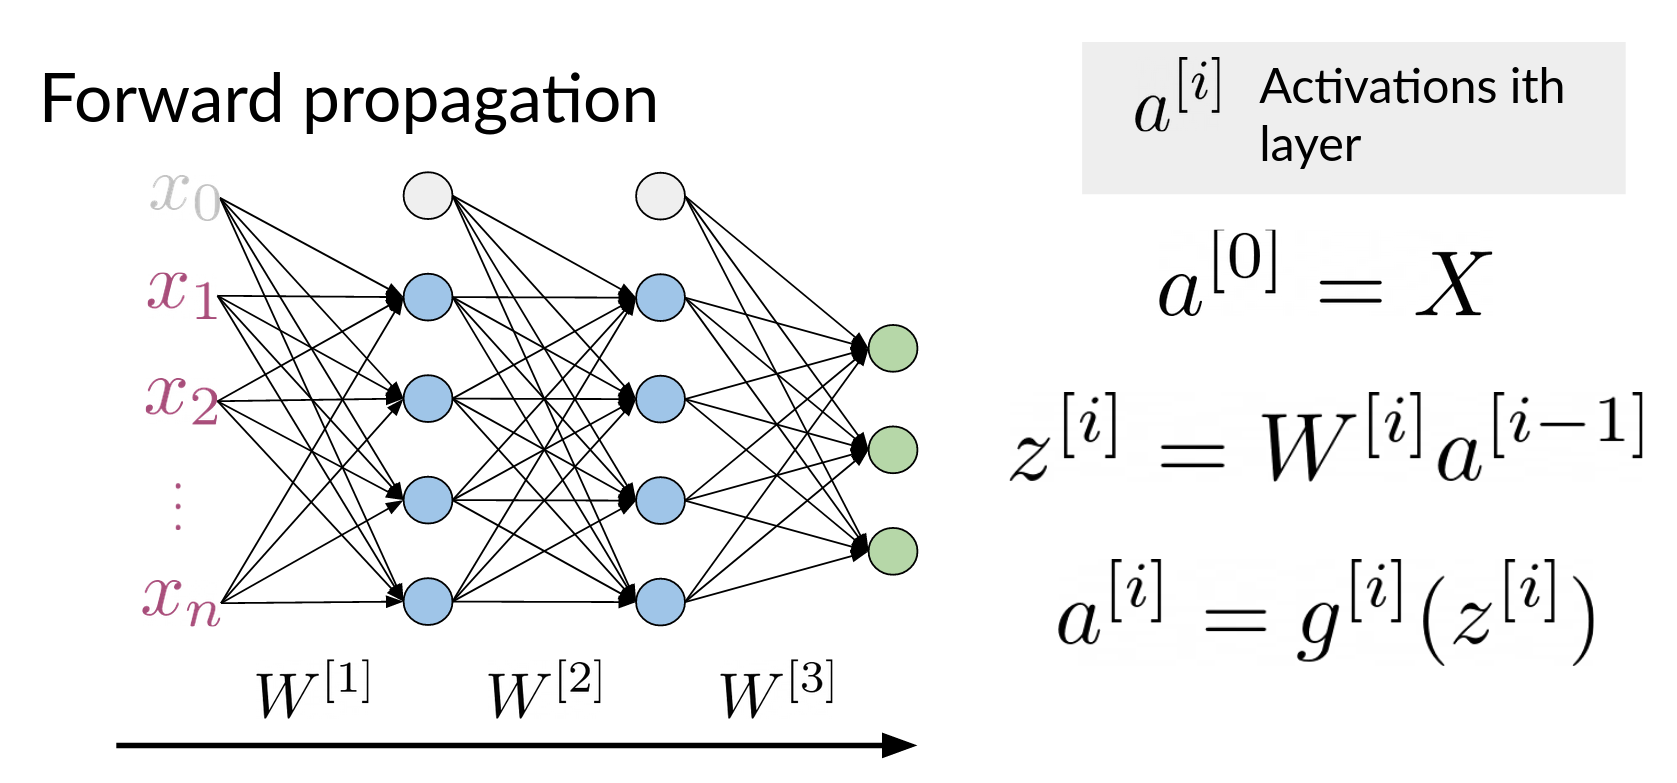

### Main layers that are very commonly used in most neural networks:
* a Dense layer which allows you to go from one layer to another inside the network
* a ReLu, layer that keeps your network stable
* an Embedding layer
* a Pooling (Mean) layer

The Dense layer is the computation of the inner product between a set of trainable weights (weight matrix) and an input vector.  The visualization of the dense layer can be seen in the image below. 

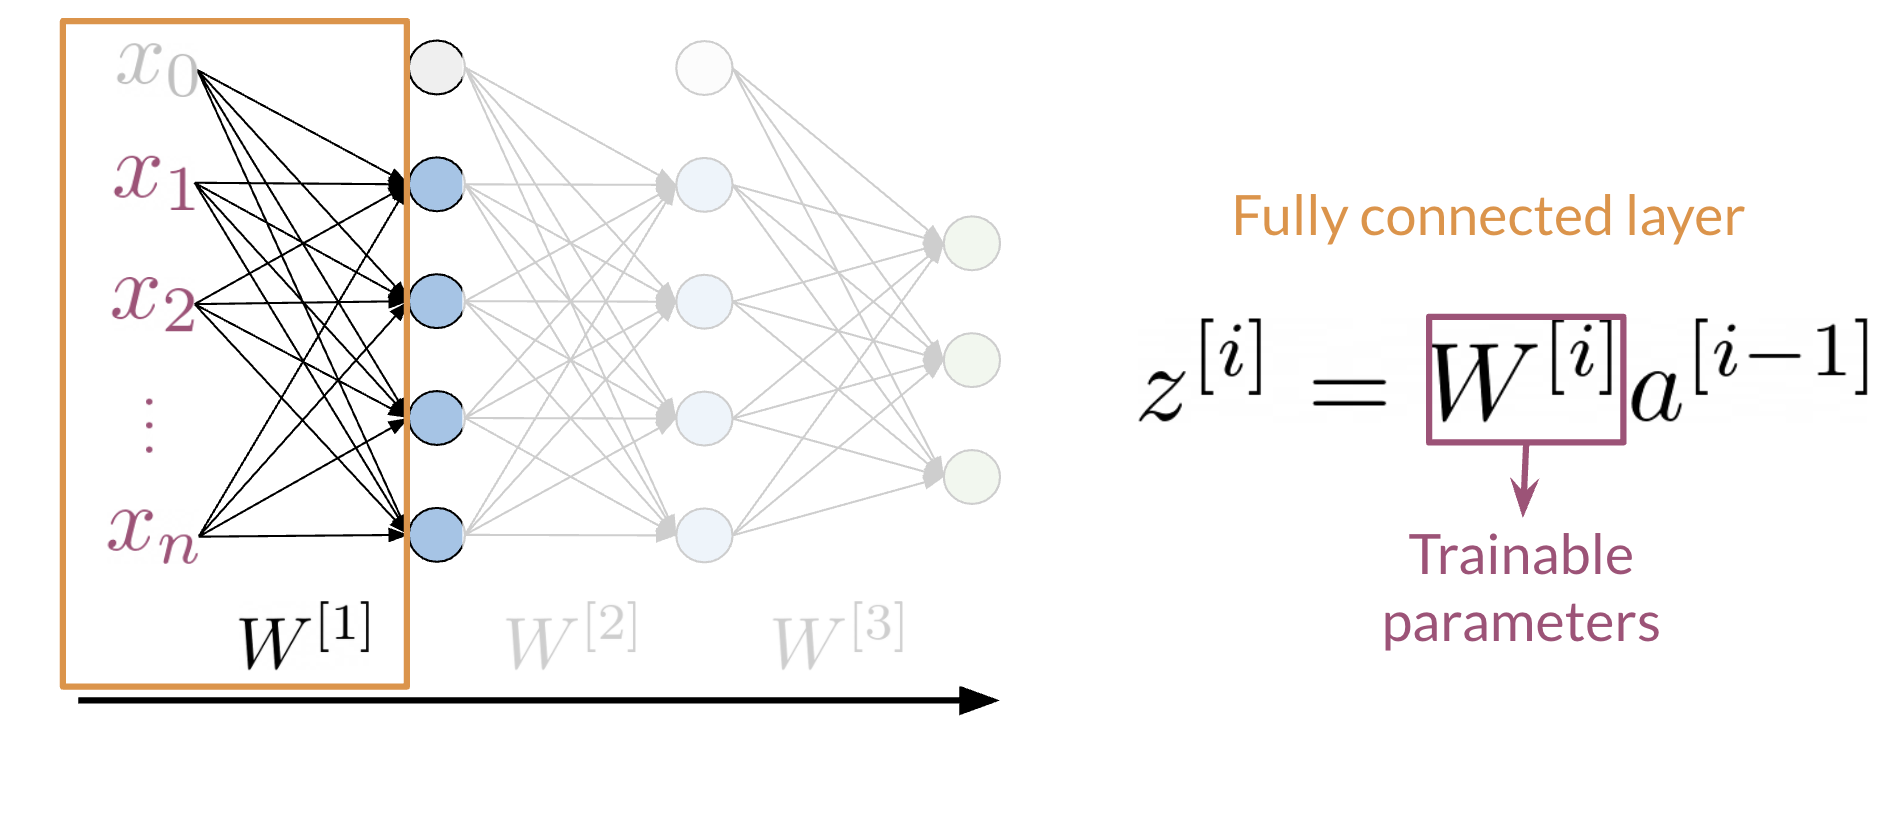

The orange box in the image above shows the dense layer. An activation layer is the set of blue nodes shown with the orange box in the image below. Concretely one of the most commonly used activation layers is the rectified linear unit (ReLU). ReLU(x) is defined as max(0,x) for any input x. 

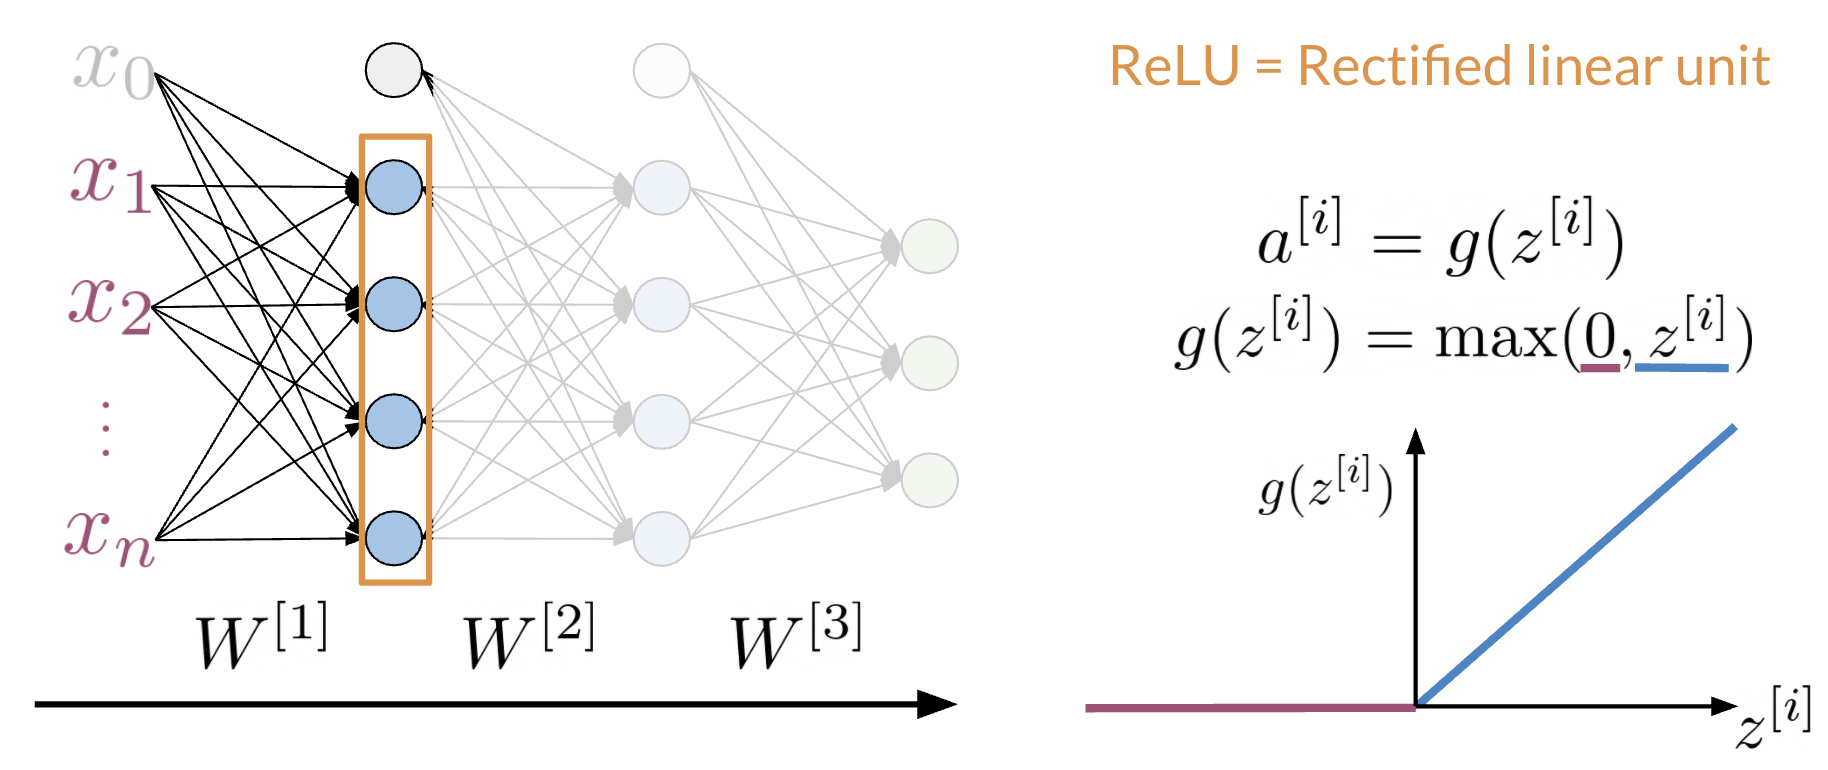

Using an embedding layer you can learn word embeddings for each word in your vocabulary.

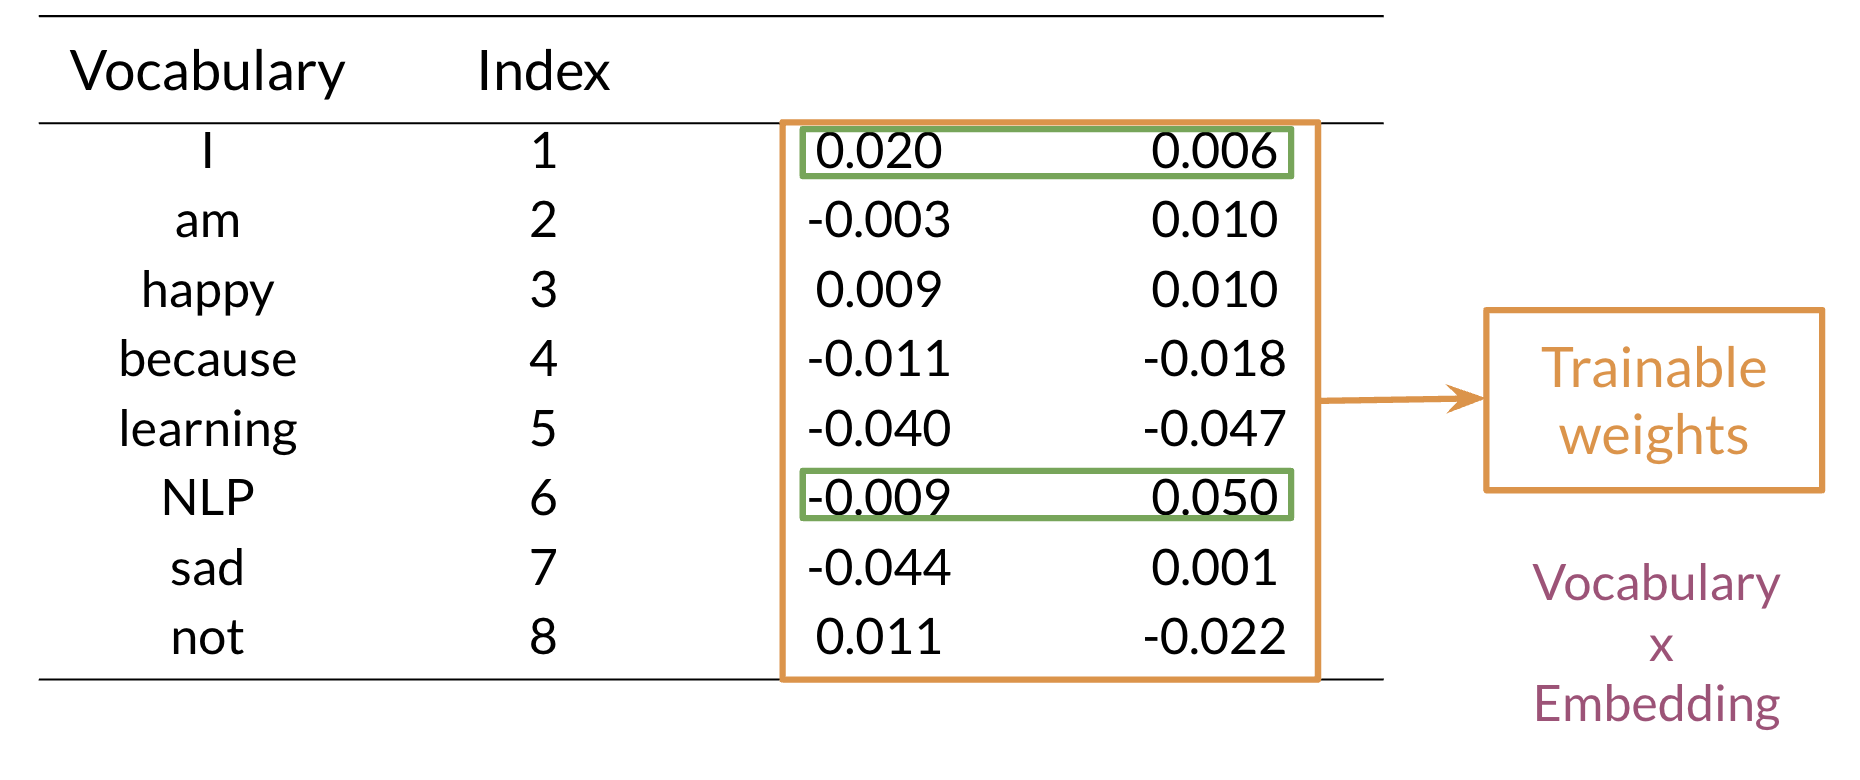

The mean layer allows you to take the average of the embeddings. This layer does not have any trainable parameters.  

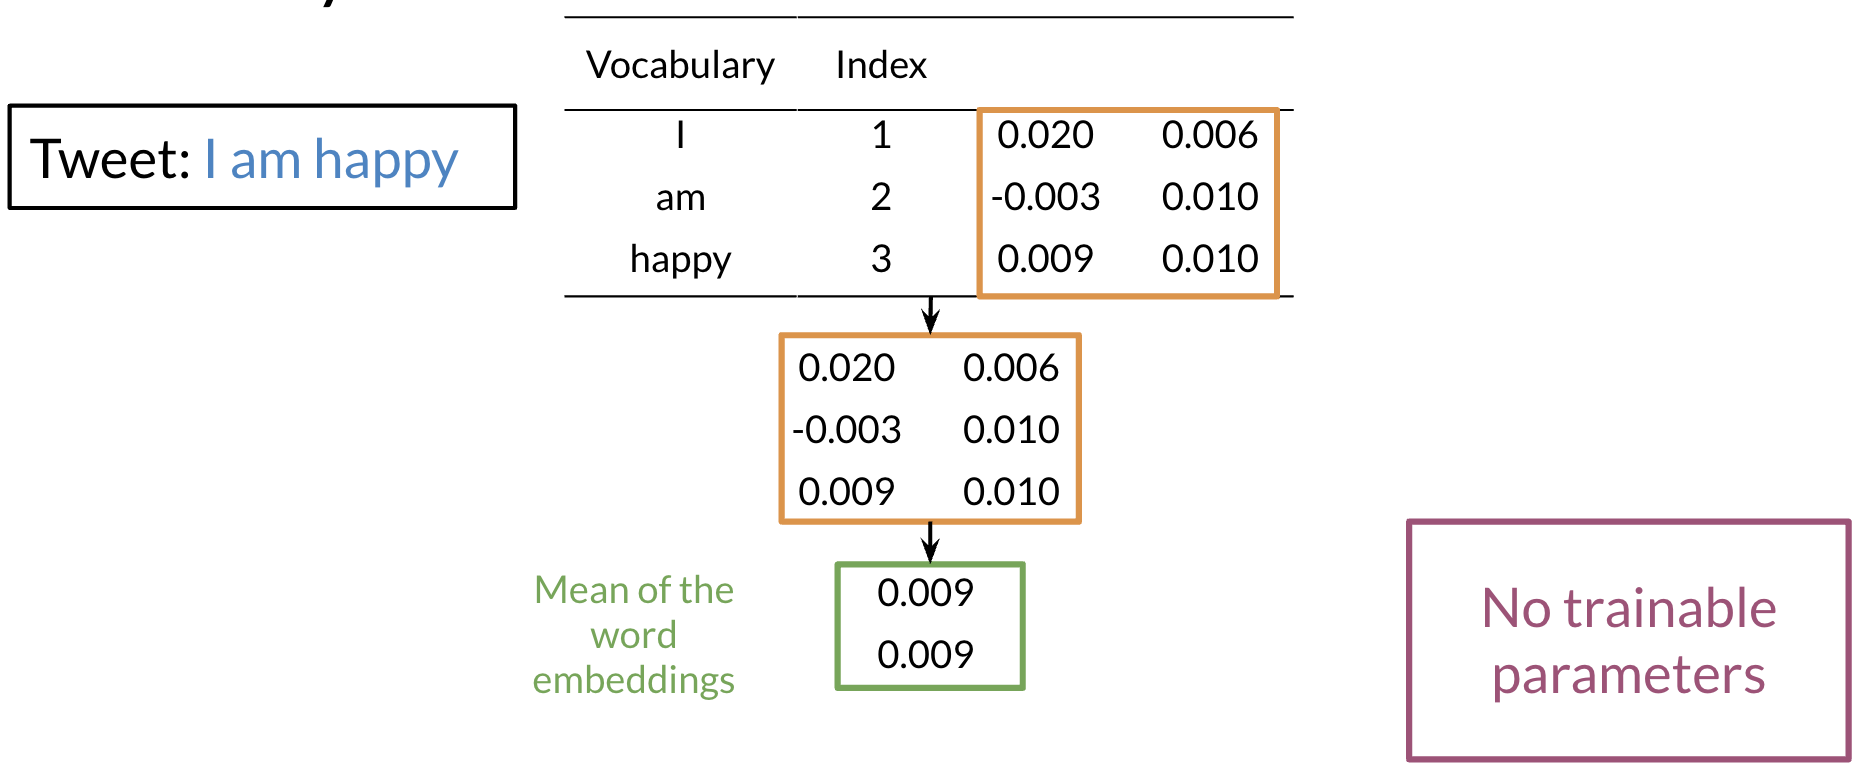

# Sentiment with Deep Neural Networks (implementation)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from utils import load_tweets, process_tweet

from tensorflow.keras.models import Model, Sequential
from tensorflow import math

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\maks1\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maks1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maks1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maks1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
# Load positive and negative tweets
all_positive_tweets, all_negative_tweets = load_tweets()

# View the total number of positive and negative tweets.
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

The number of positive tweets: 5000
The number of negative tweets: 5000


In [16]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
tweet_number = 4
print('Positive tweet example:')
print(all_positive_tweets[tweet_number])
print('\nNegative tweet example:')
print(all_negative_tweets[tweet_number])

Positive tweet example:
yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

Negative tweet example:
Dang starting next week I have "work" :(


The processing includes:

tokenizing the sentence (splitting to words)
removing stock market tickers like $GE
removing old style retweet text "RT"
removing hyperlinks
removing hashtags
lowercasing
removing stopwords and punctuation
stemming

In [17]:
# Process all the tweets: tokenize the string, remove tickers, handles, punctuation and stopwords, stem the words
all_positive_tweets_processed = [process_tweet(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [process_tweet(tweet) for tweet in all_negative_tweets]

In [19]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
tweet_number = 44
print('Positive processed tweet example:')
print(all_positive_tweets_processed[tweet_number])
print('\nNegative processed tweet example:')
print(all_negative_tweets_processed[tweet_number])

Positive processed tweet example:
['would', 'love', 'see', 'dear', 'jordan', ':)', 'wait', ':)']

Negative processed tweet example:
['pret', ':(', 'wkwkw', 'verfied', 'active', 'forget', 'follow', 'member', 'thanks', 'join', 'goodbye']


In [20]:
# Split positive set into validation and training
val_pos = all_positive_tweets_processed[4000:]
train_pos = all_positive_tweets_processed[:4000]
# Split negative set into validation and training
val_neg = all_negative_tweets_processed[4000:]
train_neg = all_negative_tweets_processed[:4000]

train_x = train_pos + train_neg 
val_x  = val_pos + val_neg

# Set the labels for the training and validation set (1 for positive, 0 for negative)
train_y = [[1] for _ in train_pos] + [[0] for _ in train_neg]
val_y  = [[1] for _ in val_pos] + [[0] for _ in val_neg]

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 8000 sentences for training.
There are 8000 labels for training.

There are 2000 sentences for validation.
There are 2000 labels for validation.


In [21]:
# FUNCTION: build_vocabulary
def build_vocabulary(corpus):
    '''Function that builds a vocabulary from the given corpus
    Input: 
        - corpus (list): the corpus
    Output:
        - vocab (dict): Dictionary of all the words in the corpus.
                The keys are the words and the values are integers.
    '''

    # The vocabulary includes special tokens like padding token and token for unknown words
    # Keys are words and values are distinct integers (increasing by one from 0)
    vocab = {'': 0, '[UNK]': 1} 
   
    # For each tweet in the training set
    for tweet in corpus:
        # For each word in the tweet
        for word in tweet:
            # If the word is not in vocabulary yet, add it to vocabulary
            if word not in vocab:
                vocab[word] = max(list(vocab.values())) + 1
        
    return vocab


vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 9535 words

{'': 0, '[UNK]': 1, 'followfriday': 2, 'top': 3, 'engage': 4, 'member': 5, 'community': 6, 'week': 7, ':)': 8, 'hey': 9, 'james': 10, 'odd': 11, ':/': 12, 'please': 13, 'call': 14, 'contact': 15, 'centre': 16, '02392441234': 17, 'able': 18, 'assist': 19, 'many': 20, 'thanks': 21, 'listen': 22, 'last': 23, 'night': 24, 'bleed': 25, 'amazing': 26, 'track': 27, 'scotland': 28, 'congrats': 29, 'yeaaah': 30, 'yipppy': 31, 'accnt': 32, 'verify': 33, 'rqst': 34, 'succeed': 35, 'get': 36, 'blue': 37, 'tick': 38, 'mark': 39, 'fb': 40, 'profile': 41, '15': 42, 'day': 43, 'one': 44, 'irresistible': 45, 'flipkartfashionfriday': 46, 'like': 47, 'keep': 48, 'lovely': 49, 'customer': 50, 'wait': 51, 'long': 52, 'hope': 53, 'enjoy': 54, 'happy': 55, 'friday': 56, 'lwwf': 57, 'second': 58, 'thought': 59, '’': 60, 'enough': 61, 'time': 62, 'dd': 63, 'new': 64, 'short': 65, 'enter': 66, 'system': 67, 'sheep': 68, 'must': 69, 'buy': 70, 'jgh': 71, 'go': 72, 'bayan': 73, ':D

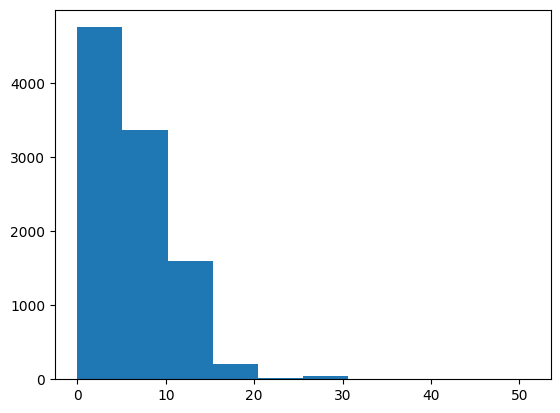

In [22]:
# Tweet lengths
plt.hist([len(t) for t in train_x + val_x]);

In [23]:
# FUNCTION: max_length
def max_length(training_x, validation_x):
    """Computes the length of the longest tweet in the training and validation sets.

    Args:
        training_x (list): The tweets in the training set.
        validation_x (list): The tweets in the validation set.

    Returns:
        int: Length of the longest tweet.
    """

    max_len = max([len(x) for x in training_x+validation_x])
    
    return max_len

max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 51 tokens.


In [24]:
# FUNCTION: padded_sequence
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    """transform sequences of words into padded sequences of numbers

    Args:
        tweet (list): A single tweet encoded as a list of strings.
        vocab_dict (dict): Vocabulary.
        max_len (int): Length of the longest tweet.
        unk_token (str, optional): Unknown token. Defaults to '[UNK]'.

    Returns:
        list: Padded tweet encoded as a list of int.
    """
    # Find the ID of the UNK token, to use it when you encounter a new word
    unk_ID = vocab_dict[unk_token] 
    
    # First convert the words to integers by looking up the vocab_dict
    word2int = [vocab_dict[x] if x in vocab_dict else unk_ID for x in tweet ]

    # Then pad the tensor with zeroes up to the length max_len
    padded_tensor = word2int + [0]*(max_len - len(word2int))

    return padded_tensor

In [25]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]

In [26]:
# FUNCTION: relu
def relu(x):
    '''Relu activation function implementation
    Input: 
        - x (numpy array)
    Output:
        - activation (numpy array): input with negative values set to zero
    '''

    activation = np.maximum(x, 0)

    return activation

In [27]:
# FUNCTION: sigmoid
def sigmoid(x):
    '''Sigmoid activation function implementation
    Input: 
        - x (numpy array)
    Output:
        - activation (numpy array)
    '''

    activation = 1 / (1 + np.exp(-x))

    return activation    

In [28]:
# CLASS: Dense
class Dense():
    """
    A dense (fully-connected) layer.
    """

    # Please implement '__init__'
    def __init__(self, n_units, input_shape, activation, stdev=0.1, random_seed=42):
        
        # Set the number of units in this layer
        self.n_units = n_units
        # Set the random key for initializing weights
        self.random_generator = np.random.default_rng(seed=random_seed)
        self.activation = activation
        
        # Generate the weight matrix from a normal distribution and standard deviation of 'stdev'
        # Set the size of the matrix w
        w = self.random_generator.normal(loc=0, scale=stdev, size=(input_shape[1], self.n_units))
        
        self.weights = w
        

    def __call__(self, x):
        return self.forward(x)
    
    
    # Please implement 'forward()'
    def forward(self, x):
        
        # Matrix multiply x and the weight matrix
        dense = np.dot(x, self.weights)
        # Apply the activation function
        dense = self.activation(dense)
        
        return dense

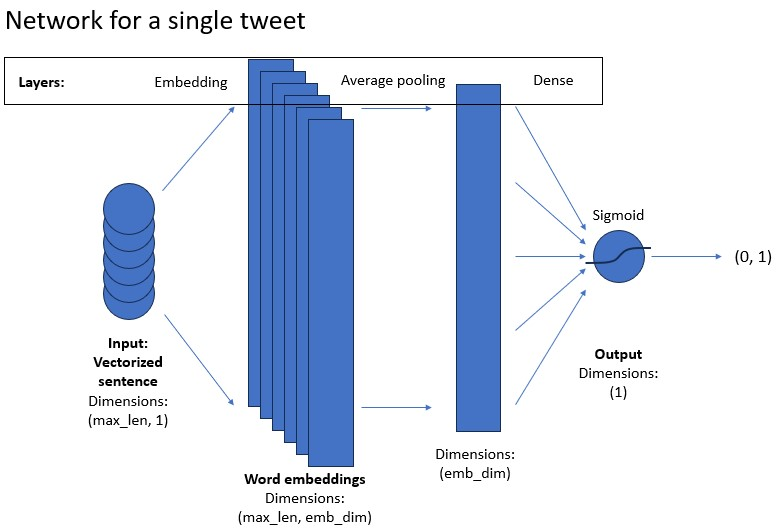

In [29]:
# FUNCTION: create_model
def create_model(num_words, embedding_dim, max_len):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        max_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
       
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [30]:
# Create the model
model = create_model(num_words=num_words, embedding_dim=16, max_len=max_len)

print('The model is created!\n')



The model is created!



In [31]:
# Prepare the data
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

print('The data is prepared for training!\n')

# Fit the model
print('Training:')
history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

The data is prepared for training!

Training:
Epoch 1/20


250/250 [==============================] - 2s 4ms/step - loss: 0.6851 - accuracy: 0.6345 - val_loss: 0.6720 - val_accuracy: 0.9665
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 0.6409 - accuracy: 0.9314 - val_loss: 0.6080 - val_accuracy: 0.9735
Epoch 3/20
250/250 [==============================] - 1s 3ms/step - loss: 0.5523 - accuracy: 0.9868 - val_loss: 0.5107 - val_accuracy: 0.9900
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4447 - accuracy: 0.9898 - val_loss: 0.4081 - val_accuracy: 0.9925
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 0.3451 - accuracy: 0.9941 - val_loss: 0.3192 - val_accuracy: 0.9920
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.2641 - accuracy: 0.9945 - val_loss: 0.2497 - val_accuracy: 0.9955
Epoch 7/20
250/250 [==============================] - 1s 3ms/step - loss: 0.2027 - accuracy: 0.9952 

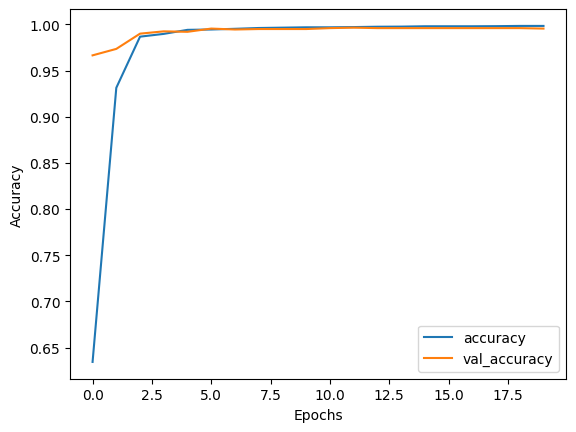

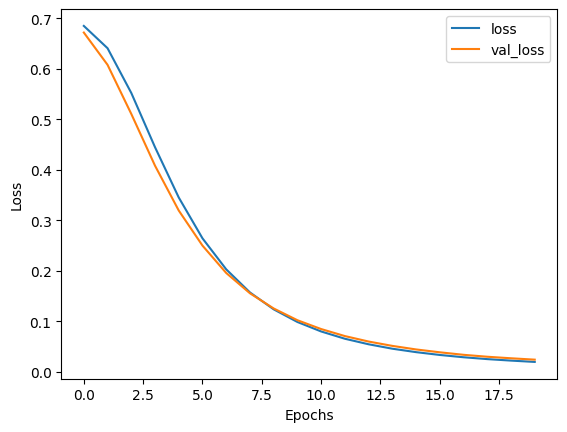

In [32]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [33]:
# Prepare an example with 10 positive and 10 negative tweets.
example_for_prediction = np.append(val_x_prepared[0:10], val_x_prepared[-10:], axis=0)

# Make a prediction on the tweets.
model.predict(example_for_prediction)

1/1 [==============================] - 0s 128ms/step


array([[0.90281415],
       [0.99428886],
       [0.9969695 ],
       [0.95045716],
       [0.99763983],
       [0.9959578 ],
       [0.99202025],
       [0.9796631 ],
       [0.9984699 ],
       [0.99830866],
       [0.01090815],
       [0.04234564],
       [0.01300239],
       [0.01709264],
       [0.01812353],
       [0.00650269],
       [0.01584858],
       [0.0083886 ],
       [0.02376341],
       [0.03456283]], dtype=float32)

In [34]:
def get_prediction_from_tweet(tweet, model, vocab, max_len):
    tweet = process_tweet(tweet)
    tweet = padded_sequence(tweet, vocab, max_len)
    tweet = np.array([tweet])

    prediction = model.predict(tweet, verbose=False)
    
    return prediction[0][0]

In [41]:
unseen_tweet = '@mak_kry NLP make a possitive effect on inhabitants and kids).'

prediction_unseen = get_prediction_from_tweet(unseen_tweet, model, vocab, max_len)
print(f"Model prediction on unseen tweet: {prediction_unseen}")

Model prediction on unseen tweet: 0.5101087689399719


In [36]:
# Get the embedding layer
embeddings_layer = model.layers[0]

# Get the weights of the embedding layer
embeddings = embeddings_layer.get_weights()[0]

# PCA with two dimensions
pca = PCA(n_components=2)

# Dimensionality reduction of the word embeddings
embeddings_2D = pca.fit_transform(embeddings)

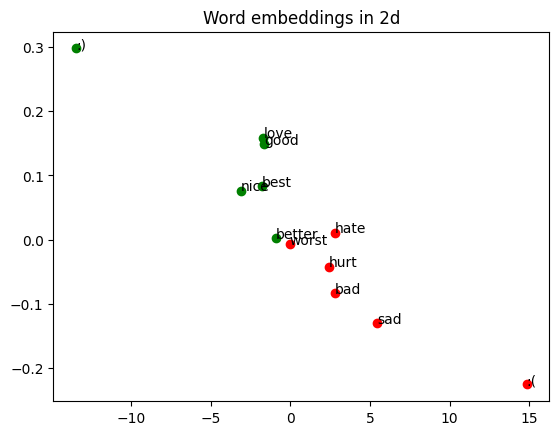

In [38]:
#Selection of negative and positive words
neg_words = ['bad', 'hurt', 'sad', 'hate', 'worst', ':(']
pos_words = ['best', 'good', 'nice', 'love', 'better', ':)']

#Index of each selected word
neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(embeddings_2D[neg_n][:,0], embeddings_2D[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (embeddings_2D[neg_n][i,0], embeddings_2D[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(embeddings_2D[pos_n][:,0], embeddings_2D[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(embeddings_2D[pos_n][i,0], embeddings_2D[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()

# Recurrent Neural Networks (RNN) for Language Models

RNNs is able to track dependencies that are much further apart from each other. As the RNN makes its way through a text corpus, it picks up some information. Note that as you feed in more information into the model, the previous word's retention gets weaker, but it is still there. Look at the orange rectangle above and see how it becomes smaller as you make your way through the text. This shows that your model is capable of capturing dependencies and remembers a previous word although it is at the beginning of a sentence or paragraph. Another advantage of RNNs is that a lot of the computation shares parameters. 

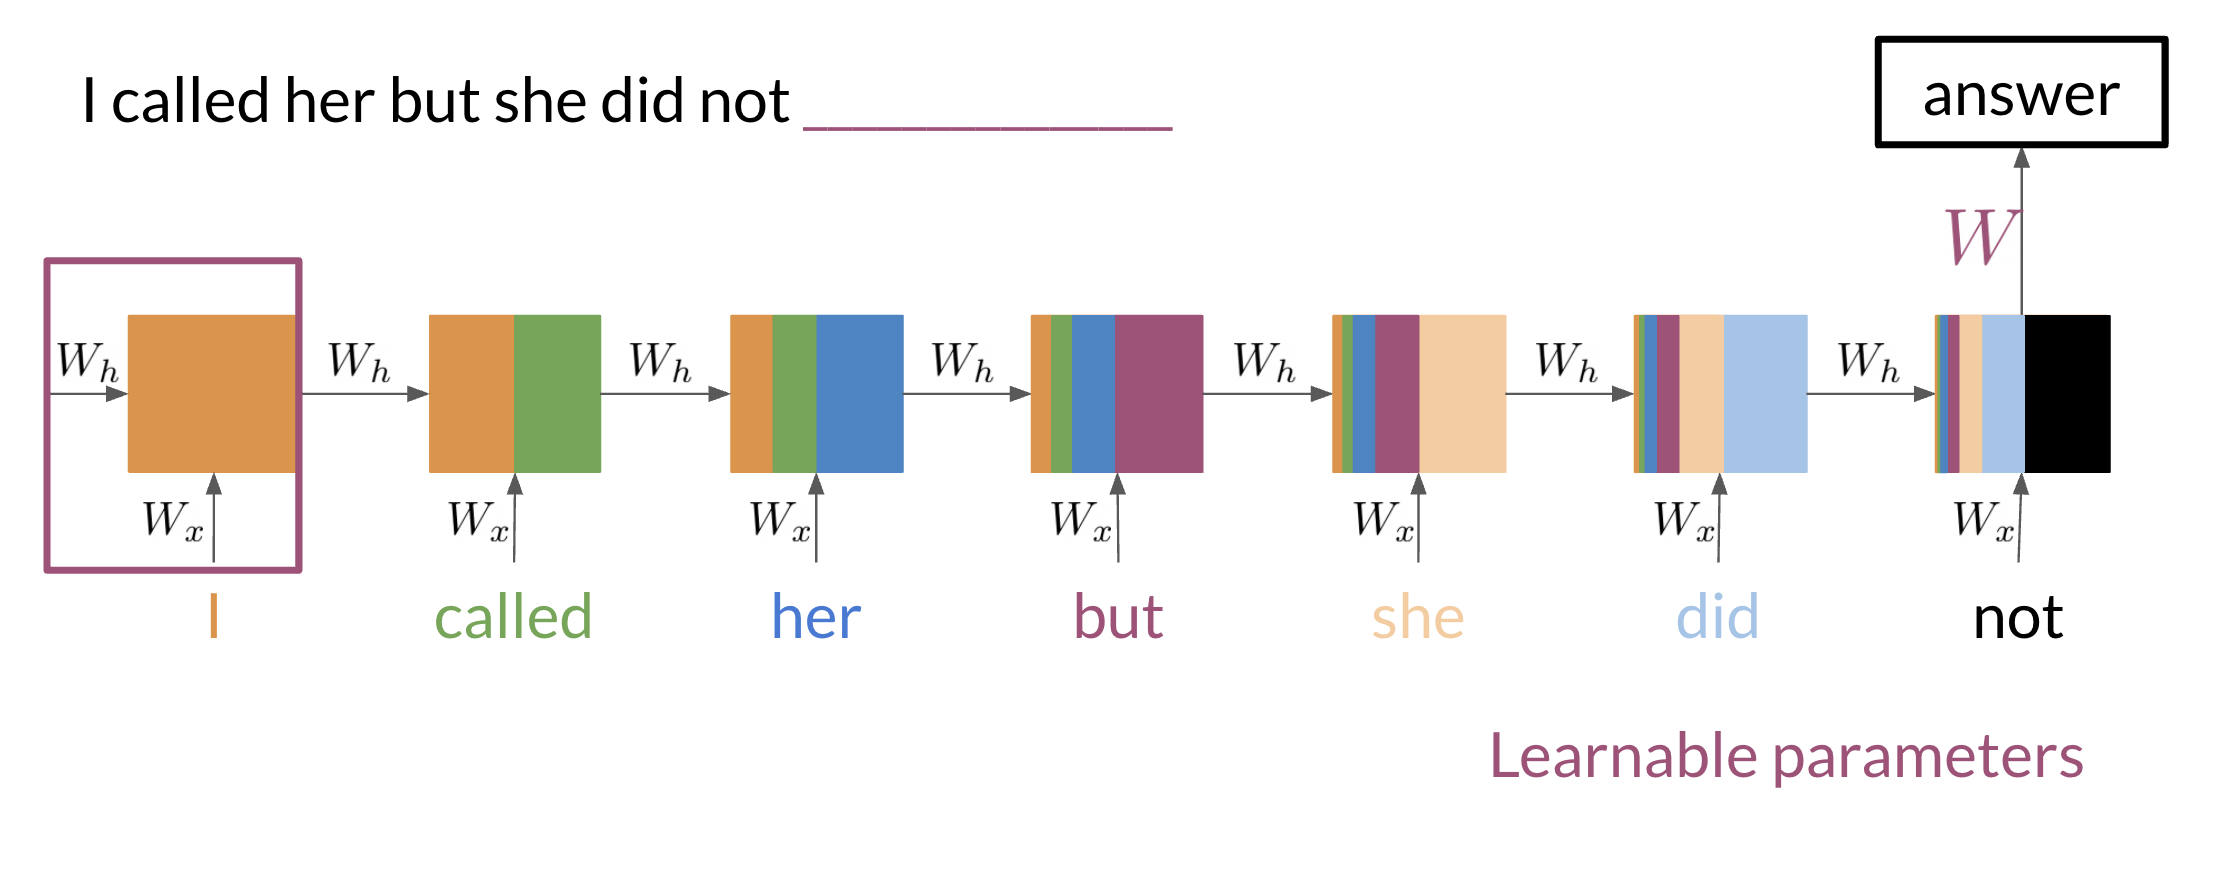

#### RNNs could be used in a variety of tasks ranging from machine translation to caption generation. There are many ways to implement an RNN model:

* One to One: given some scores of a championship, you can predict the winner. 

* One to Many: given an image, you can predict what the caption is going to be.

* Many to One: given a tweet, you can predict the sentiment of that tweet. 

* Many to Many: given an english sentence, you can translate it to its German equivalent. 

A vanilla RNN (Recurrent Neural Network) is a type of neural network architecture designed for processing sequential data. It is characterized by its recurrent connections, which allow information to be passed from one step of the sequence to the next. This makes them suitable for tasks where the order of input elements matters, such as time series prediction, natural language processing, and speech recognition. 

However, vanilla RNNs have limitations, such as difficulties in learning long-term dependencies due to the vanishing gradient problem, making it challenging to learn from distant past information.

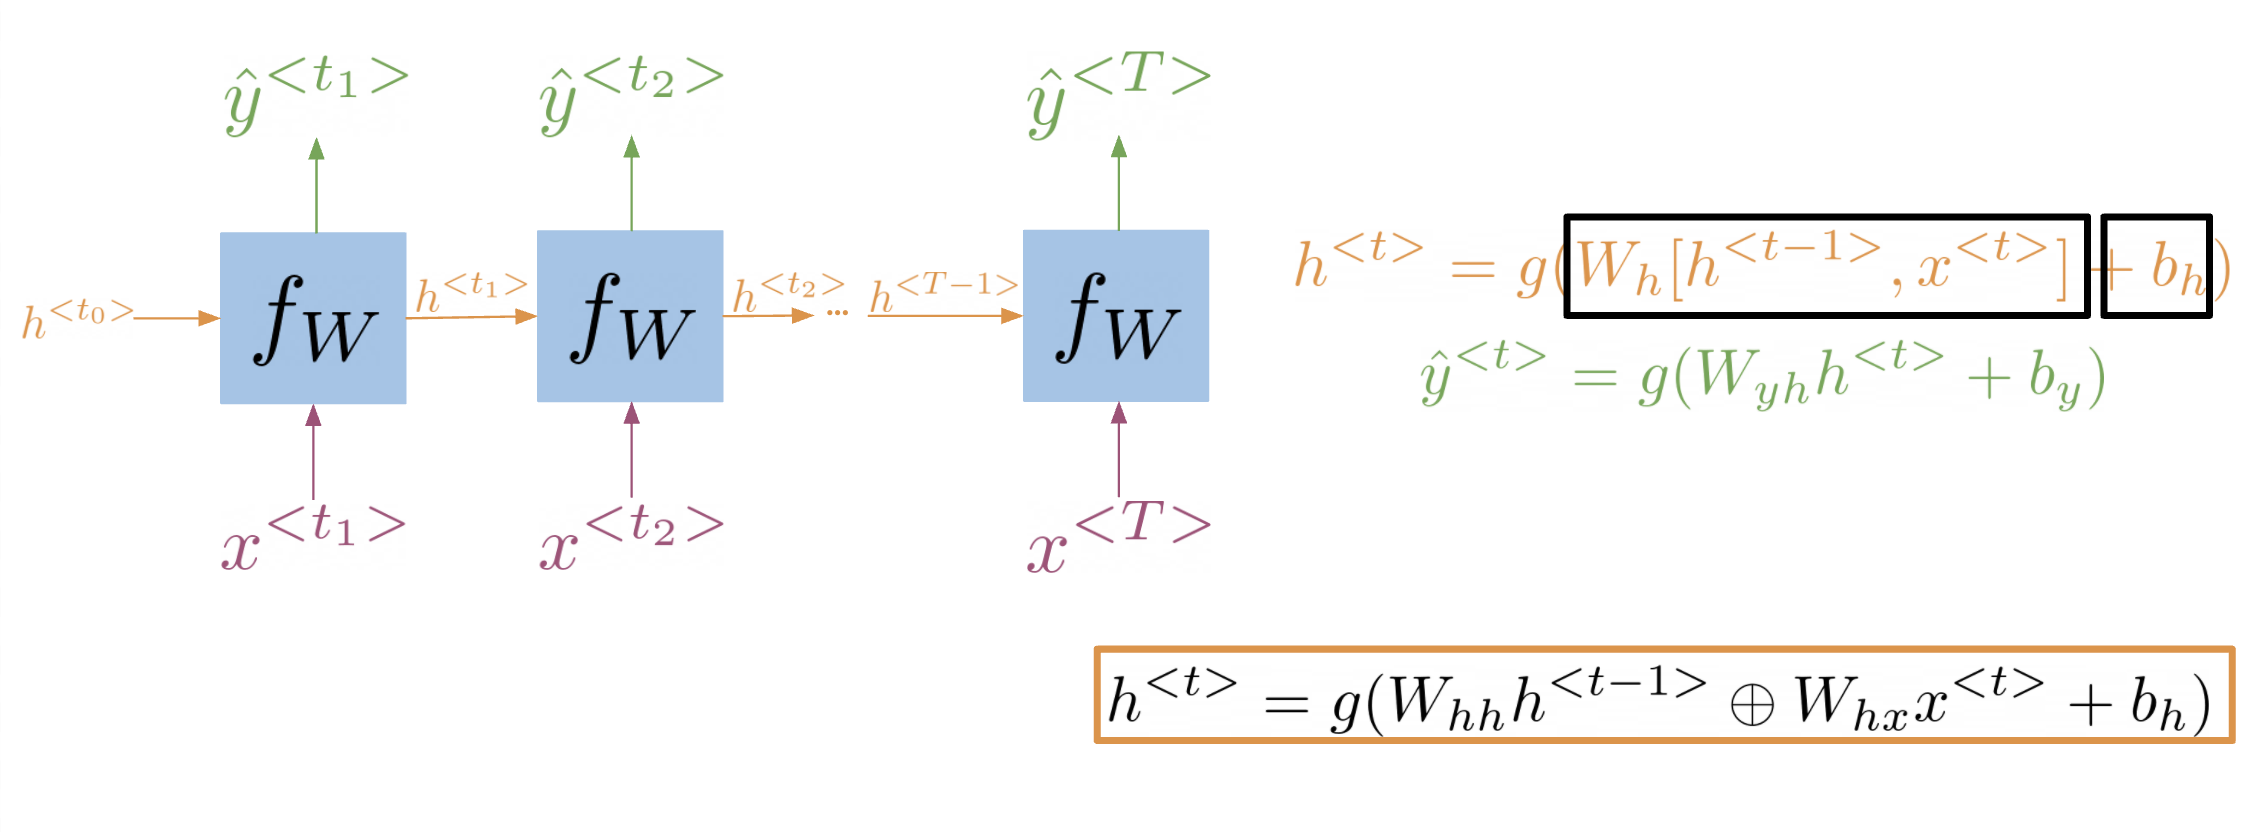

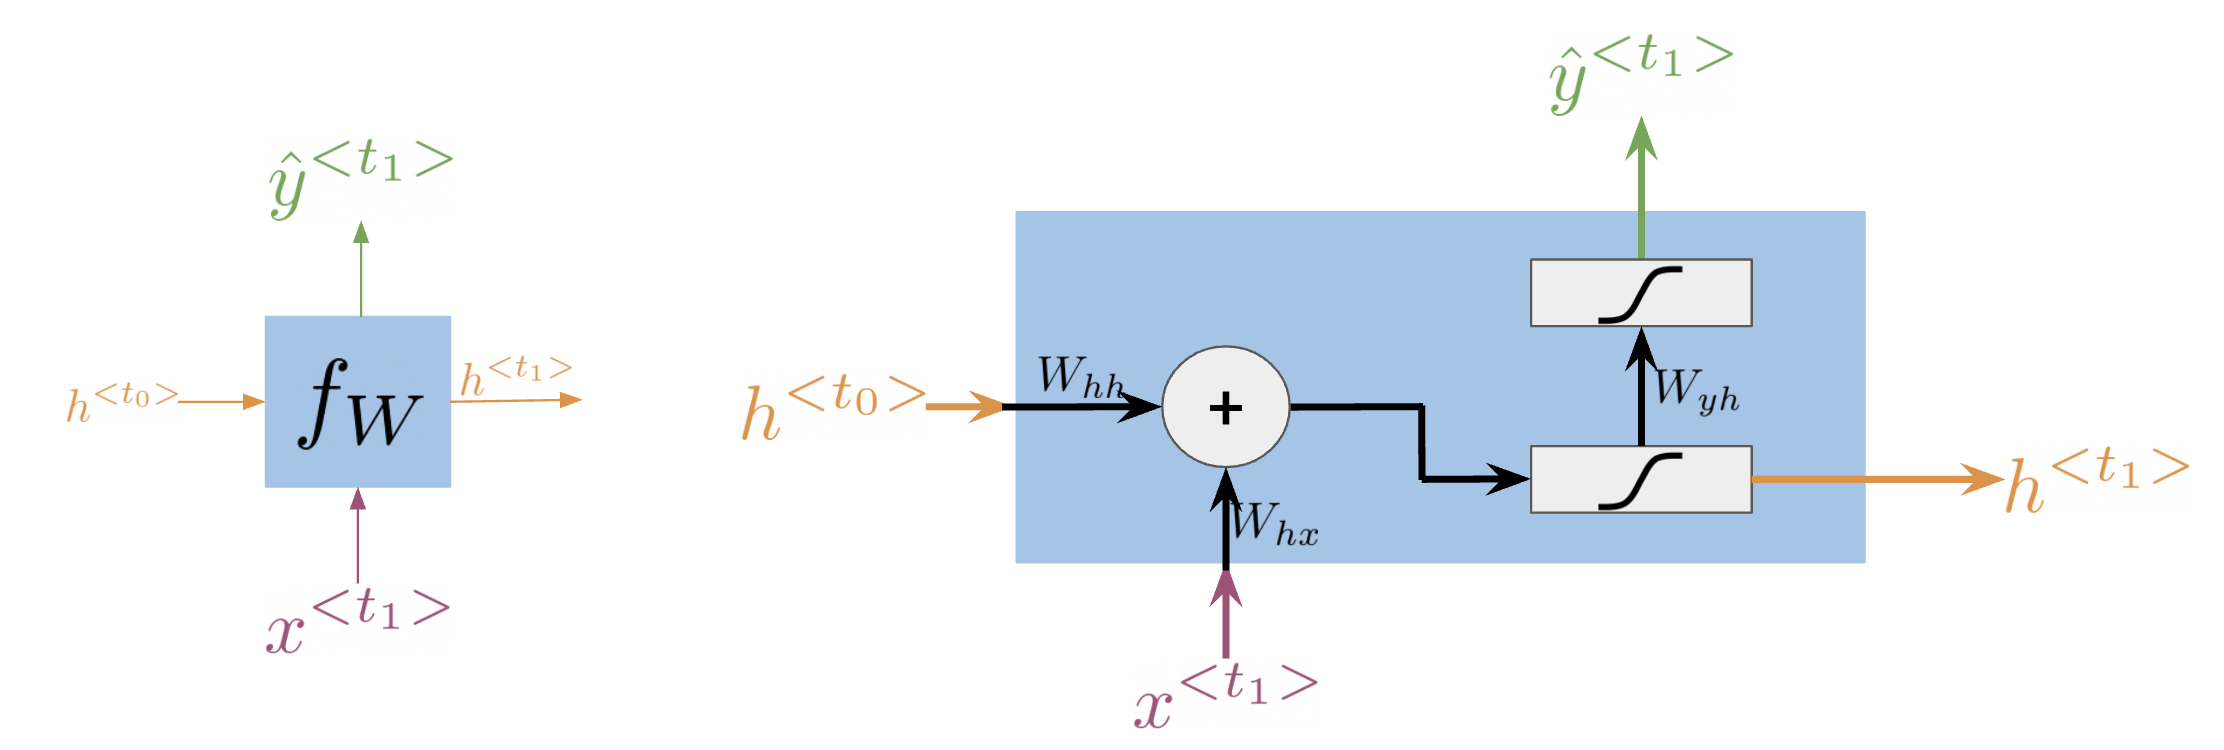

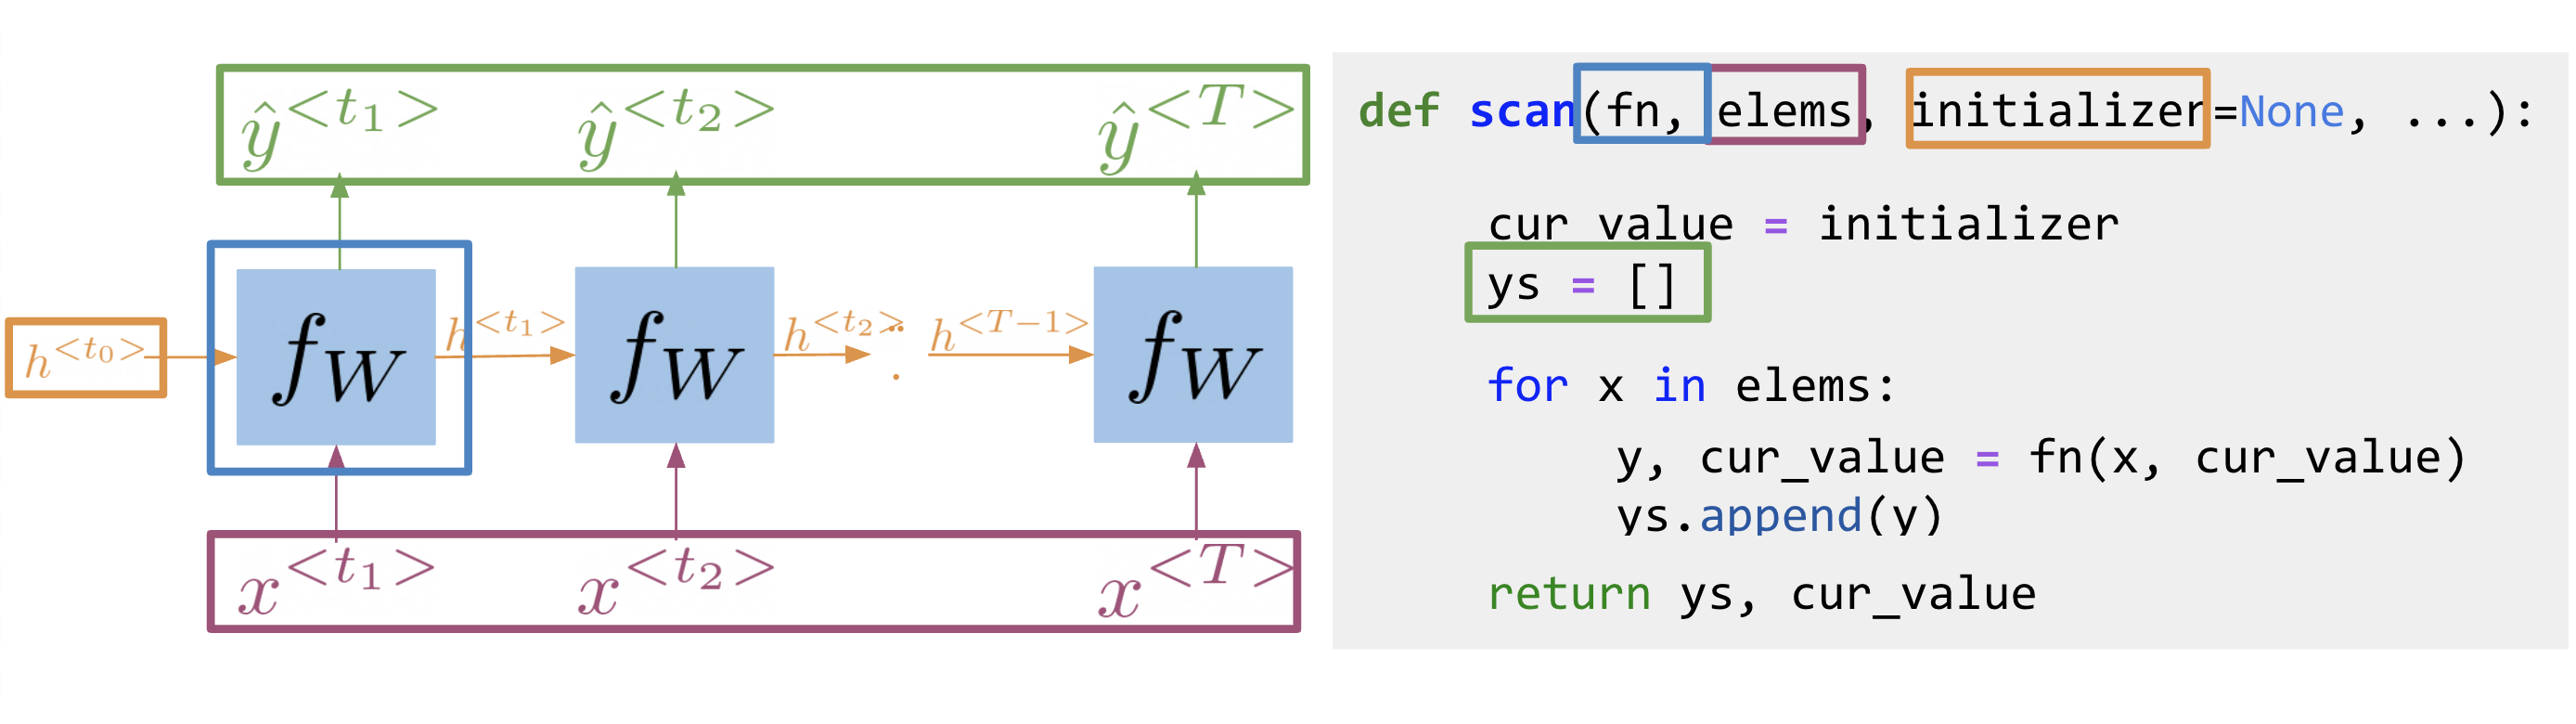

Note, that is basically what an RNN is doing. It takes the initializer, and returns a list of outputs (ys), and uses the current value, to get the next y and the next current value. These type of abstractions allow for much faster computation.

# Gated recurrent units (GRU) 

Gated recurrent units are very similar to vanilla RNNs, except that they have a "relevance" and "update" gate that allow the model to update and get relevant information. I personally find it easier to understand by looking at the formulas:

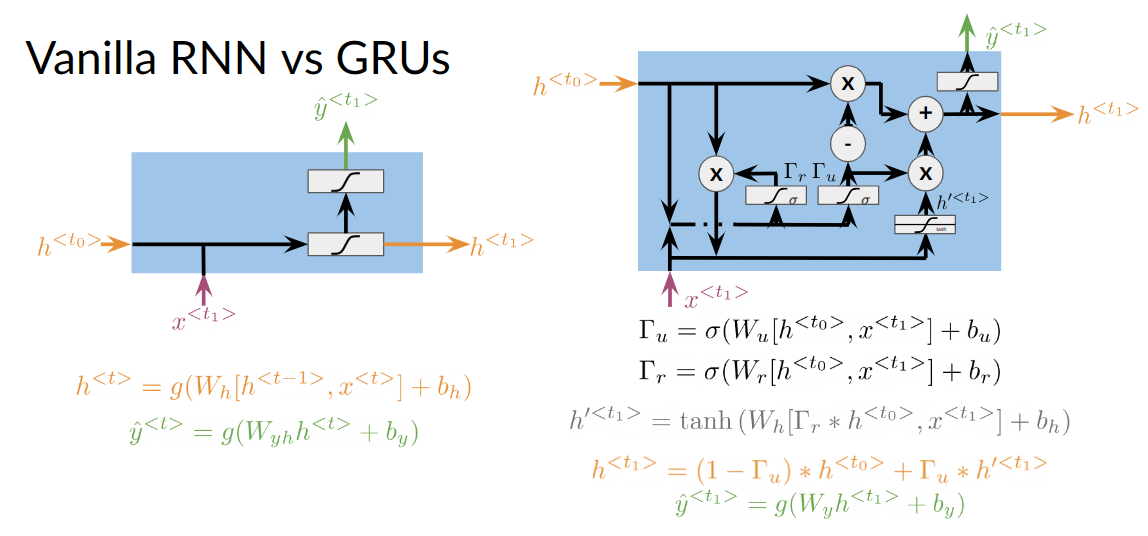

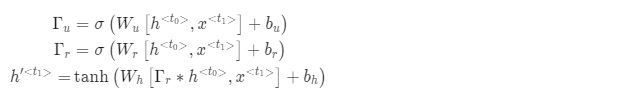

* The first gate Γu allows you to decide how much you want to update the weights by. 
* The second gate Γr, helps you find a relevance score. 

You can compute the new h by using the relevance gate. Finally you can compute h, using the update gate. GRUs “decide” how to update the hidden state. GRUs help preserve important information.

In [ ]:
def forward_V_RNN(inputs, weights): # Forward propagation for a a single vanilla RNN cell
    x, h_t = inputs

    # weights.
    wh, bh = weights

    # new hidden state
    h_t = np.dot(wh, np.concatenate([h_t, x])) + bh
    h_t = sigmoid(h_t)
    
    # We avoid implementation of y for clarity
    y = h_t
    
    return y, h_t

In [ ]:
def forward_GRU(inputs, weights): # Forward propagation for a single GRU cell
    x, h_t = inputs

    # weights.
    wu, wr, wc, bu, br, bc = weights

    # Update gate
    u = np.dot(wu, np.concatenate([h_t, x])) + bu
    u = sigmoid(u)
    
    # Relevance gate
    r = np.dot(wr, np.concatenate([h_t, x])) + br
    r = sigmoid(r)
    
    # Candidate hidden state 
    c = np.dot(wc, np.concatenate([r * h_t, x])) + bc
    c = np.tanh(c)
    
    # New Hidden state h_t
    h_t = u * c + (1 - u) * h_t
    
    # We avoid implementation of y for clarity
    y = h_t
    
    return y, h_t

In [ ]:
# EXAMPLE OF GRU WITH TENSORFLOW
model_GRU = tf.keras.Sequential([
    #  If you want to stack two consecutive GRU layers, you need the first one to output a sequence, which you can achieve by setting the parameter *return_sequences*
    tf.keras.layers.GRU(256, return_sequences=True, name='GRU_1_returns_seq'),
    tf.keras.layers.GRU(128, return_sequences=True, name='GRU_2_returns_seq'),
    tf.keras.layers.GRU(64, name='GRU_3_returns_last_only'),
    tf.keras.layers.Dense(10)
])

# Deep and Bi-directional RNNs

**Bi-directional RNNs** are important, because knowing what is next in the sentence could give you more context about the sentence itself. So you can see, in order to make a prediction y_hat, you will use the hidden states from both directions and combine them to make one hidden state, you can then proceed as you would with a simple vanilla RNN.


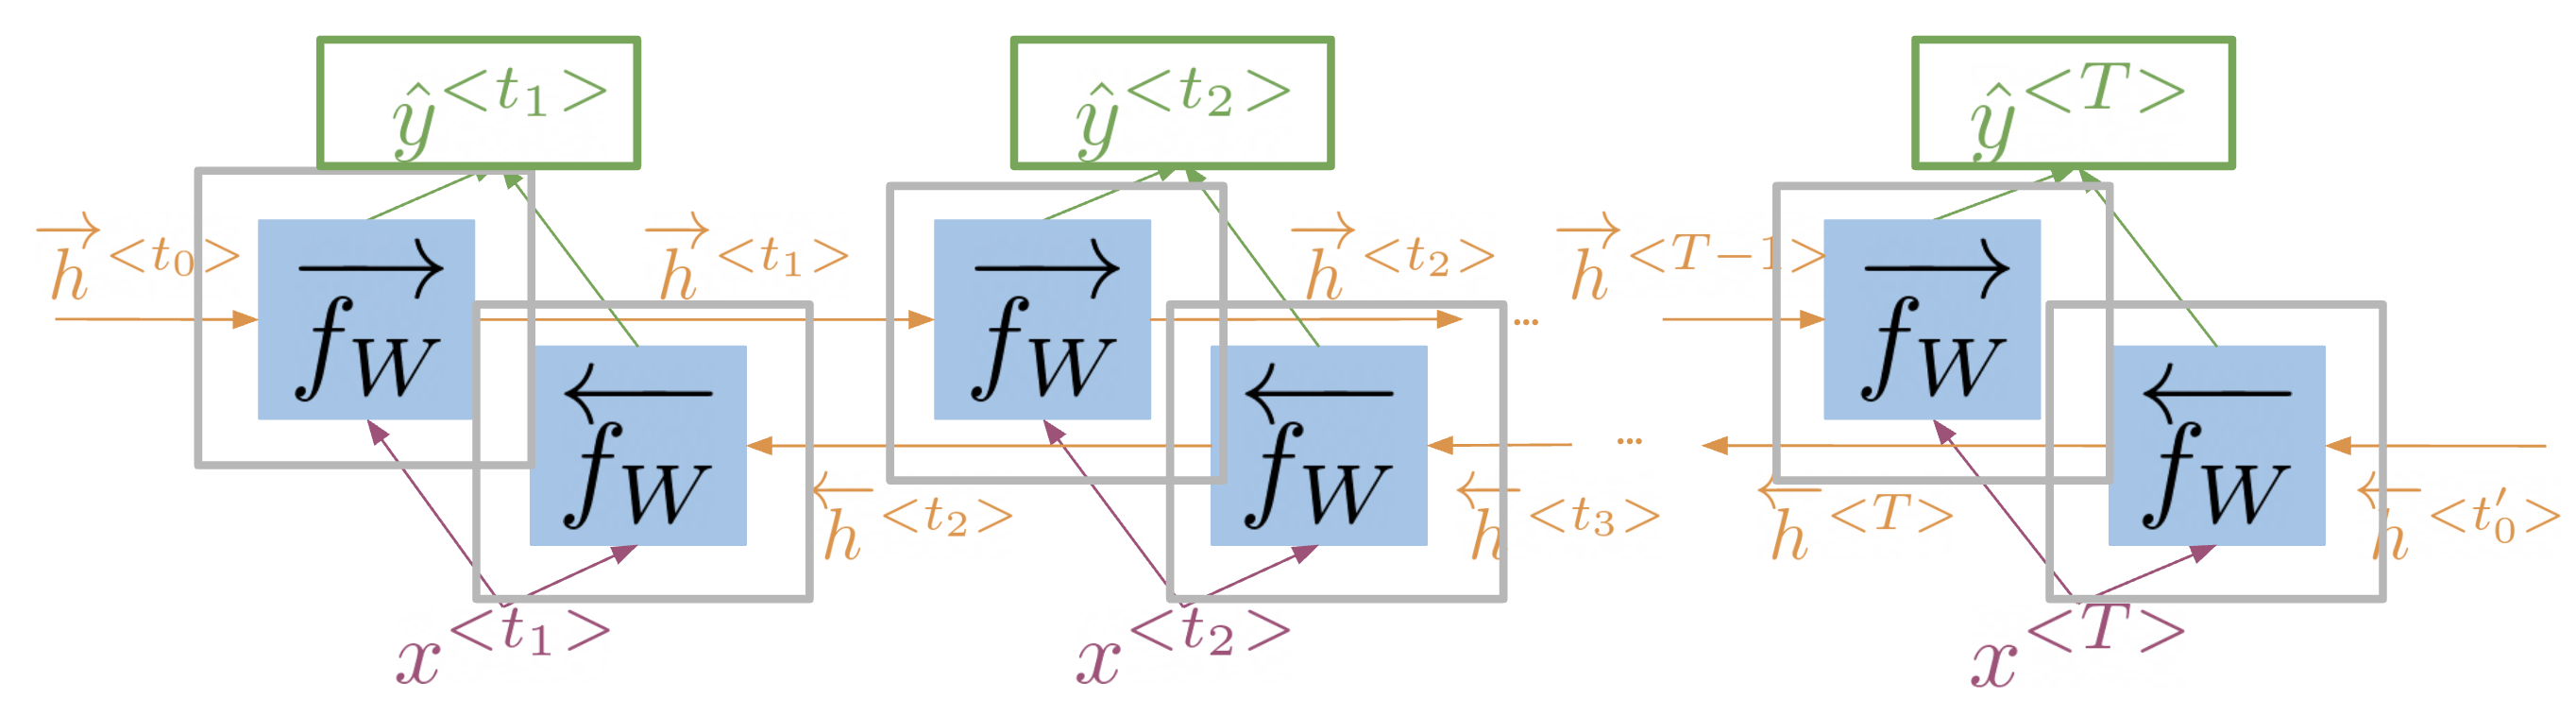

**Deep RNNs** is just RNN with multiple layers. Note that at layer l, you are using the input from the bottom a_[l−1] and the hidden state h_l. That allows you to get your new h, and then to get your new a, you will train another weight matrix W_a, which you will multiply by the corresponding h add the bias and then run it through an activation layer. 

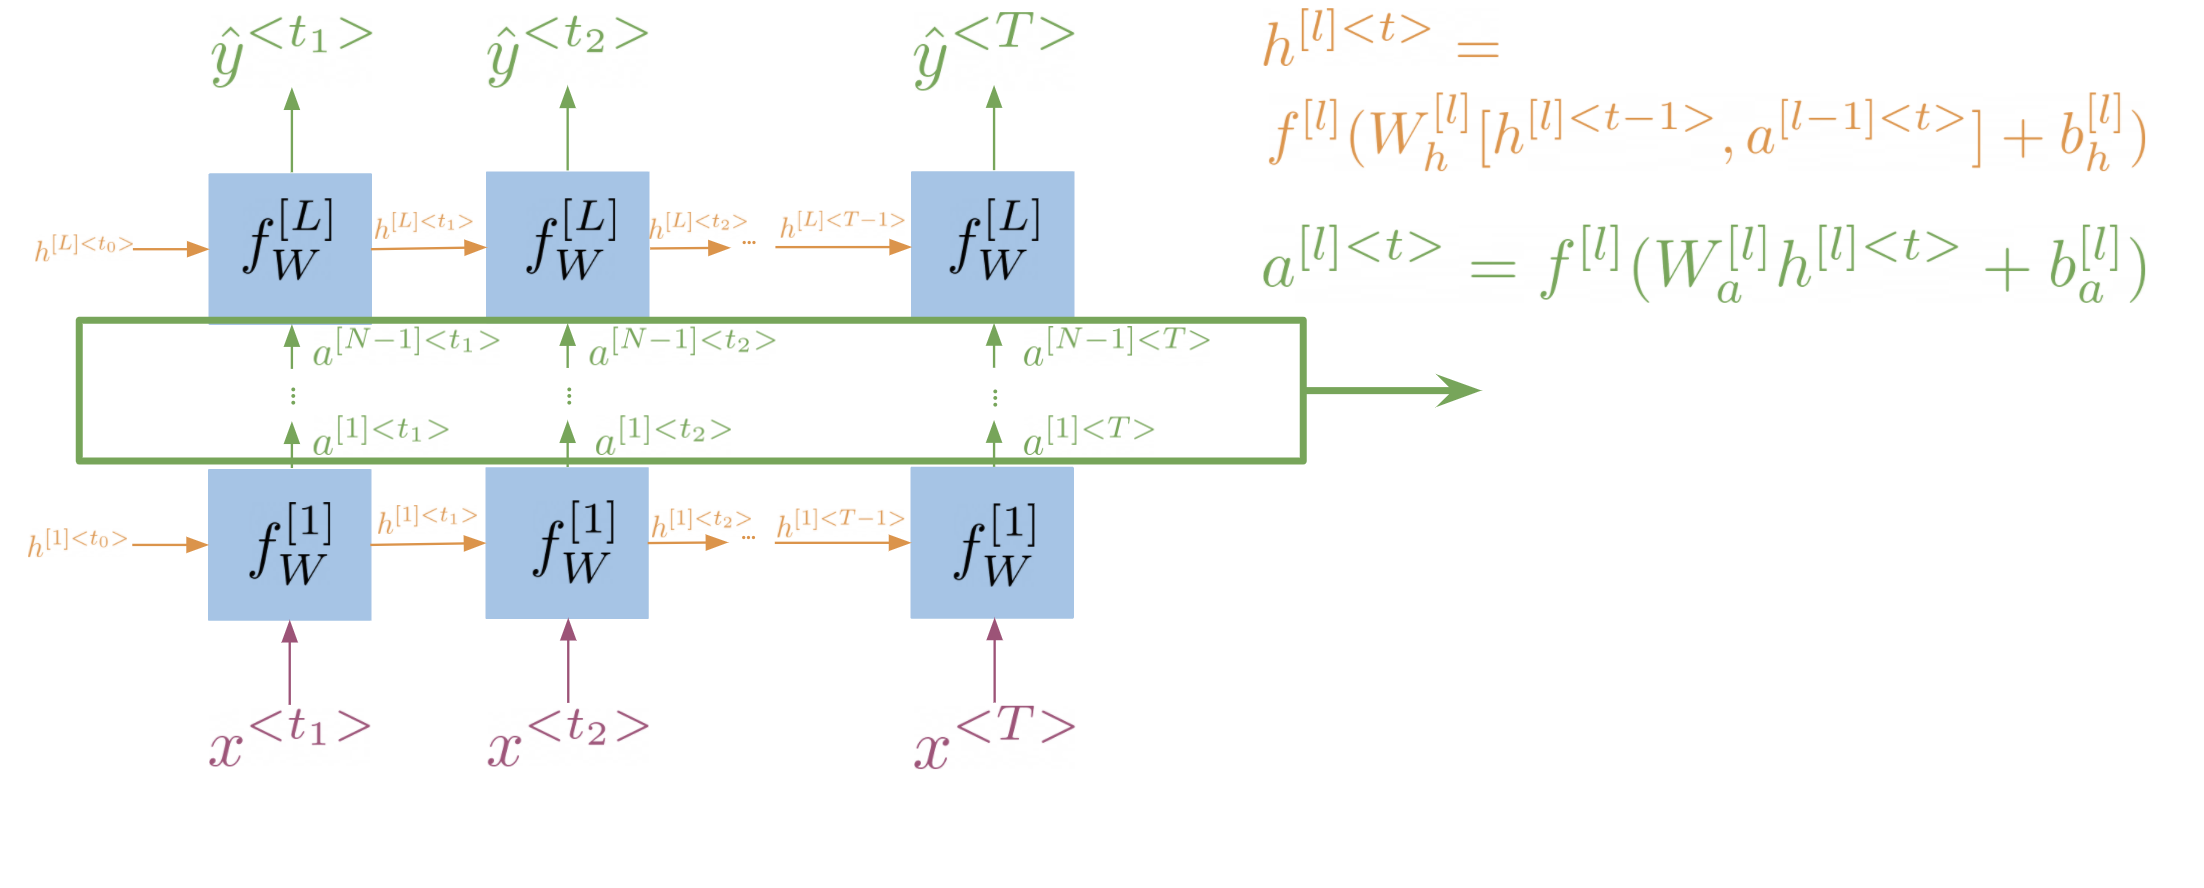

# GRU (implementation)

In this task, you'll delve into the world of text generation using Recurrent Neural Networks (RNNs). Your primary objective is to predict the next set of characters based on the preceding ones. This seemingly straightforward task holds immense practicality in applications like predictive text and creative writing.

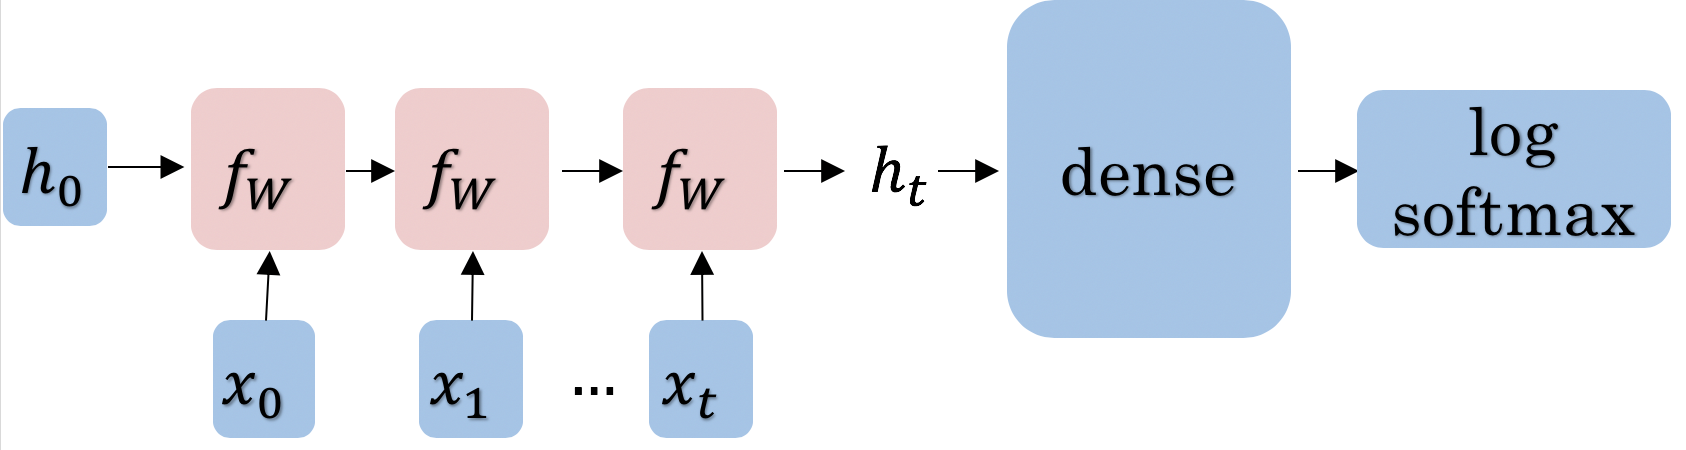

In [ ]:
# Loading in the Data
dirname = 'data/'
filename = 'shakespeare_data.txt'
lines = [] # storing all the lines in a variable. 

counter = 0

with open(os.path.join(dirname, filename)) as files:
    for line in files:        
        # remove leading and trailing whitespace
        pure_line = line.strip()#.lower()

        # if pure_line is not the empty string,
        if pure_line:
            # append it to the list
            lines.append(pure_line)
            
n_lines = len(lines)
print(f"Number of lines: {n_lines}")

In [ ]:
# Create the vocabulary
text = "\n".join(lines)
# The unique characters in the file
vocab = sorted(set(text))
vocab.insert(0,"[UNK]") # Add a special character for any unknown
vocab.insert(1,"") # Add the empty character for padding.

print(f'{len(vocab)} unique characters')
print(" ".join(vocab))

In [ ]:
# FUNCTION: line_to_tensor
def line_to_tensor(line, vocab):
    """
    Converts a line of text into a tensor of integer values representing characters.

    Args:
        line (str): A single line of text.
        vocab (list): A list containing the vocabulary of unique characters.

    Returns:
        tf.Tensor(dtype=int64): A tensor containing integers (unicode values) corresponding to the characters in the `line`.
    """
    # Split the input line into individual characters
    chars = tf.strings.unicode_split(line, input_encoding='UTF-8')
    # Map characters to their respective integer values using StringLookup
    ids = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None)(chars)
    
    return ids

In [ ]:
def text_from_ids(ids, vocab):
    """
    Converts a tensor of integer values into human-readable text.

    Args:
        ids (tf.Tensor): A tensor containing integer values (unicode IDs).
        vocab (list): A list containing the vocabulary of unique characters.

    Returns:
        str: A string containing the characters in human-readable format.
    """
    # Initialize the StringLookup layer to map integer IDs back to characters
    chars_from_ids = tf.keras.layers.StringLookup(vocabulary=vocab, invert=True, mask_token=None)
    
    # Use the layer to decode the tensor of IDs into human-readable text
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
# Prepare your data for training and testing
train_lines = lines[:-1000] # Leave the rest for training
eval_lines = lines[-1000:] # Create a holdout validation set

print(f"Number of training lines: {len(train_lines)}")
print(f"Number of validation lines: {len(eval_lines)}")

In [ ]:
# Create the input and the output for your model
def split_input_target(sequence):
    """
    Splits the input sequence into two sequences, where one is shifted by one position.

    Args:
        sequence (tf.Tensor or list): A list of characters or a tensor.

    Returns:
        tf.Tensor, tf.Tensor: Two tensors representing the input and output sequences for the model.
    """
    # Create the input sequence by excluding the last character
    input_text = sequence[:-1]
    # Create the target sequence by excluding the first character
    target_text = sequence[1:]

    return input_text, target_text

In [ ]:
# FUNCTION: create_batch_dataset
def create_batch_dataset(lines, vocab, seq_length=100, batch_size=64):
    """
    Creates a batch dataset from a list of text lines.

    Args:
        lines (list): A list of strings with the input data, one line per row.
        vocab (list): A list containing the vocabulary.
        seq_length (int): The desired length of each sample.
        batch_size (int): The batch size.

    Returns:
        tf.data.Dataset: A batch dataset generator.
    """
    # Buffer size to shuffle the dataset
    # (TF data is designed to work with possibly infinite sequences,
    # so it doesn't attempt to shuffle the entire sequence in memory. Instead,
    # it maintains a buffer in which it shuffles elements).
    BUFFER_SIZE = 10000
    
    # For simplicity, just join all lines into a single line
    single_line_data  = "\n".join(lines)
   
    # Convert your data into a tensor using the given vocab
    all_ids = line_to_tensor(single_line_data, vocab)
    # Create a TensorFlow dataset from the data tensor
    ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
    # Create a batch dataset
    data_generator = ids_dataset.batch(seq_length + 1, drop_remainder=True) 
    # Map each input sample using the split_input_target function
    dataset_xy = data_generator.map(split_input_target)
    
    # Assemble the final dataset with shuffling, batching, and prefetching
    dataset = (                                   
        dataset_xy                                
        .shuffle(BUFFER_SIZE)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)  
        )            
                                         
    return dataset

In [ ]:
# Create the training dataset
# Batch size
BATCH_SIZE = 64
dataset = create_batch_dataset(train_lines, vocab, seq_length=100, batch_size=BATCH_SIZE)

In [ ]:
# CLASS: GRULM
class GRULM(tf.keras.Model):
    """
    A GRU-based language model that maps from a tensor of tokens to activations over a vocabulary.

    Args:
        vocab_size (int, optional): Size of the vocabulary. Defaults to 256.
        embedding_dim (int, optional): Depth of embedding. Defaults to 256.
        rnn_units (int, optional): Number of units in the GRU cell. Defaults to 128.

    Returns:
        tf.keras.Model: A GRULM language model.
    """
    def __init__(self, vocab_size=256, embedding_dim=256, rnn_units=128):
        super().__init__(self)

        # Create an embedding layer to map token indices to embedding vectors
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define a GRU (Gated Recurrent Unit) layer for sequence modeling
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)  
            # return_sequences: It specifies if the model returns a sequence of predictions. 
            # return_state:     It specifies if the model must return the last internal state along with the prediction. 

        # Apply a dense layer with log-softmax activation to predict next tokens
        self.dense = tf.keras.layers.Dense(vocab_size, activation=tf.nn.log_softmax)
            
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        # Map input tokens to embedding vectors
        x = self.embedding(x, training=training)
        if states is None:
            # Get initial state from the GRU layer
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        # Predict the next tokens and apply log-softmax activation
        x = self.dense(x, training=training)
        if return_state:
            return x, states
        else:
            return x

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = 82

# The embedding dimension
embedding_dim = 256

# RNN layers
rnn_units = 512

model = GRULM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units = rnn_units)

In [ ]:
# Simulate inputs of length 100. This allows to compute the shape of all inputs and outputs of our network
model.build(input_shape=(BATCH_SIZE, 100))
model.call(Input(shape=(100)))
model.summary() 

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    print("Input: ", input_example_batch[0].numpy()) # Lets use only the first sequence on the batch
    example_batch_predictions = model(tf.constant([input_example_batch[0].numpy()]))
    print("\n",example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
# FUNCTION: Compile model
def compile_model(model):
    """
    Sets the loss and optimizer for the given model

    Args:
        model (tf.keras.Model): The model to compile.

    Returns:
        tf.keras.Model: The compiled model.
    """
    # Define the loss function. Use SparseCategoricalCrossentropy 
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    # The Sparce Categorical Cross Entropy loss. It is the loss function used for multiclass classification.
    # from_logits=True: This parameter informs the loss function that the output values generated by the model are not normalized like a probability distribution. 
    # This is our case, since our GRULM model uses a log_softmax activation rather than the softmax.
    
    # Define and Adam optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=125e-5)
    # Compile the model using the parametrized Adam optimizer and the SparseCategoricalCrossentropy funcion
    model.compile(optimizer=opt, loss=loss)
    
    return model

In [ ]:
# Train model
EPOCHS = 10

# Compile the model
model = compile_model(model)
# Fit the model
history = model.fit(dataset, epochs=EPOCHS)

In [ ]:
# save the final model
# output_dir = './your-model/'

# try:
#     shutil.rmtree(output_dir)
# except OSError as e:
#     pass

# model.save_weights(output_dir)

In [ ]:
# FUNCTION: log_perplexity
def log_perplexity(preds, target):
    """
    Function to calculate the log perplexity of a model.

    Args:
        preds (tf.Tensor): Predictions of a list of batches of tensors corresponding to lines of text.
        target (tf.Tensor): Actual list of batches of tensors corresponding to lines of text.

    Returns:
        float: The log perplexity of the model.
    """
    PADDING_ID = 1
    
    # Calculate log probabilities for predictions using one-hot encoding
    log_p = np.sum(preds * tf.one_hot(target, preds.shape[-1]), axis=-1) 
    # Identify non-padding elements in the target
    non_pad = 1.0 - np.equal(target, PADDING_ID)         # You should check if the target equals to PADDING_ID
    # Apply non-padding mask to log probabilities to exclude padding
    log_p = log_p * non_pad                             # Get rid of the padding
    # Calculate the log perplexity by taking the sum of log probabilities and dividing by the sum of non-padding elements
    log_ppx = np.sum(log_p, axis=-1) / np.sum(non_pad, axis=-1) # Remember to set the axis properly when summing up
    # Compute the mean of log perplexity
    log_ppx = np.mean(log_ppx) # Compute the mean of the previous expression
        
    return -log_ppx

In [ ]:
#for line in eval_lines[1:3]:
eval_text = "\n".join(eval_lines)
eval_ids = line_to_tensor([eval_text], vocab)
input_ids, target_ids = split_input_target(tf.squeeze(eval_ids, axis=0))

preds, status = model(tf.expand_dims(input_ids, 0), training=False, states=None, return_state=True)

#Get the log perplexity
log_ppx = log_perplexity(preds, tf.expand_dims(target_ids, 0))
print(f'The log perplexity and perplexity of your model are {log_ppx} and {np.exp(log_ppx)} respectively')

In [ ]:
def temperature_random_sampling(log_probs, temperature=1.0):
    """Temperature Random sampling from a categorical distribution. The higher the temperature, the more 
       random the output. If temperature is close to 0, it means that the model will just return the index
       of the character with the highest input log_score
    
    Args:
        log_probs (tf.Tensor): The log scores for each characeter in the dictionary
        temperature (number): A value to weight the random noise. 
    Returns:
        int: The index of the selected character
    """
   # Generate uniform random numbers with a slight offset to avoid log(0)
    u = tf.random.uniform(minval=1e-6, maxval=1.0 - 1e-6, shape=log_probs.shape)
    
    # Apply the Gumbel distribution transformation for randomness
    g = -tf.math.log(-tf.math.log(u))
    
    # Adjust the logits with the temperature and choose the character with the highest score
    return tf.math.argmax(log_probs + g * temperature, axis=-1)

In [ ]:
# CLASS: GenerativeModel
class GenerativeModel(tf.keras.Model):
    def __init__(self, model, vocab, temperature=1.0):
        """
        A generative model for text generation.

        Args:
            model (tf.keras.Model): The underlying model for text generation.
            vocab (list): A list containing the vocabulary of unique characters.
            temperature (float, optional): A value to control the randomness of text generation. Defaults to 1.0.
        """
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.vocab = vocab
    
    @tf.function
    def generate_one_step(self, inputs, states=None):
        """
        Generate a single character and update the model state.

        Args:
            inputs (string): The input string to start with.
            states (tf.Tensor): The state tensor.

        Returns:
            tf.Tensor, states: The predicted character and the current GRU state.
        """
        # Convert strings to token IDs.
        
        # Transform the inputs into tensors
        input_ids = line_to_tensor(inputs, self.vocab)
        # Predict the sequence for the given input_ids. Use the states and return_state=True
        predicted_logits, states = self.model(input_ids, states, return_state=True)
        # Get only last element of the sequence
        predicted_logits = predicted_logits[0, -1, :]                      
        # Use the temperature_random_sampling to generate the next character. 
        predicted_ids = temperature_random_sampling(predicted_logits, self.temperature)
        # Use the chars_from_ids to transform the code into the corresponding char
        predicted_chars = text_from_ids([predicted_ids], self.vocab)
               
        # Return the characters and model state.
        return tf.expand_dims(predicted_chars, 0), states
    
    def generate_n_chars(self, num_chars, prefix):
        """
        Generate a text sequence of a specified length, starting with a given prefix.

        Args:
            num_chars (int): The length of the output sequence.
            prefix (string): The prefix of the sequence (also referred to as the seed).

        Returns:
            str: The generated text sequence.
        """
        states = None
        next_char = tf.constant([prefix])
        result = [next_char]
        for n in range(num_chars):
            next_char, states = self.generate_one_step(next_char, states=states)
            result.append(next_char)

        return tf.strings.join(result)[0].numpy().decode('utf-8')

In [ ]:
# Fix the seed to get replicable results for testing
tf.random.set_seed(272)
gen = GenerativeModel(model, vocab, temperature=0.5)

print(gen.generate_n_chars(32, " "), '\n\n' + '_'*80)
print(gen.generate_n_chars(32, "Dear"), '\n\n' + '_'*80)
print(gen.generate_n_chars(32, "KING"), '\n\n' + '_'*80)

In [ ]:
# generate a longer text
tf.random.set_seed(np.random.randint(1, 1000))
gen = GenerativeModel(model, vocab, temperature=0.8)
import time
start = time.time()
print(gen.generate_n_chars(1000, "ROMEO "), '\n\n' + '_'*80)
print('\nRun time:', time.time() - start)

# Named Entity Recognition (NER) with Long Short Term Memory (LSTM)

#### Advantages of RNNs
RNNs allow us to capture dependencies within a short range and they take up less RAM than other n-gram models. 

#### Disadvantages of RNNs
RNNs struggle with longer term dependencies and are very prone to vanishing or exploding gradients.

Note that as you are back-propagating through time, you end up getting the following: 

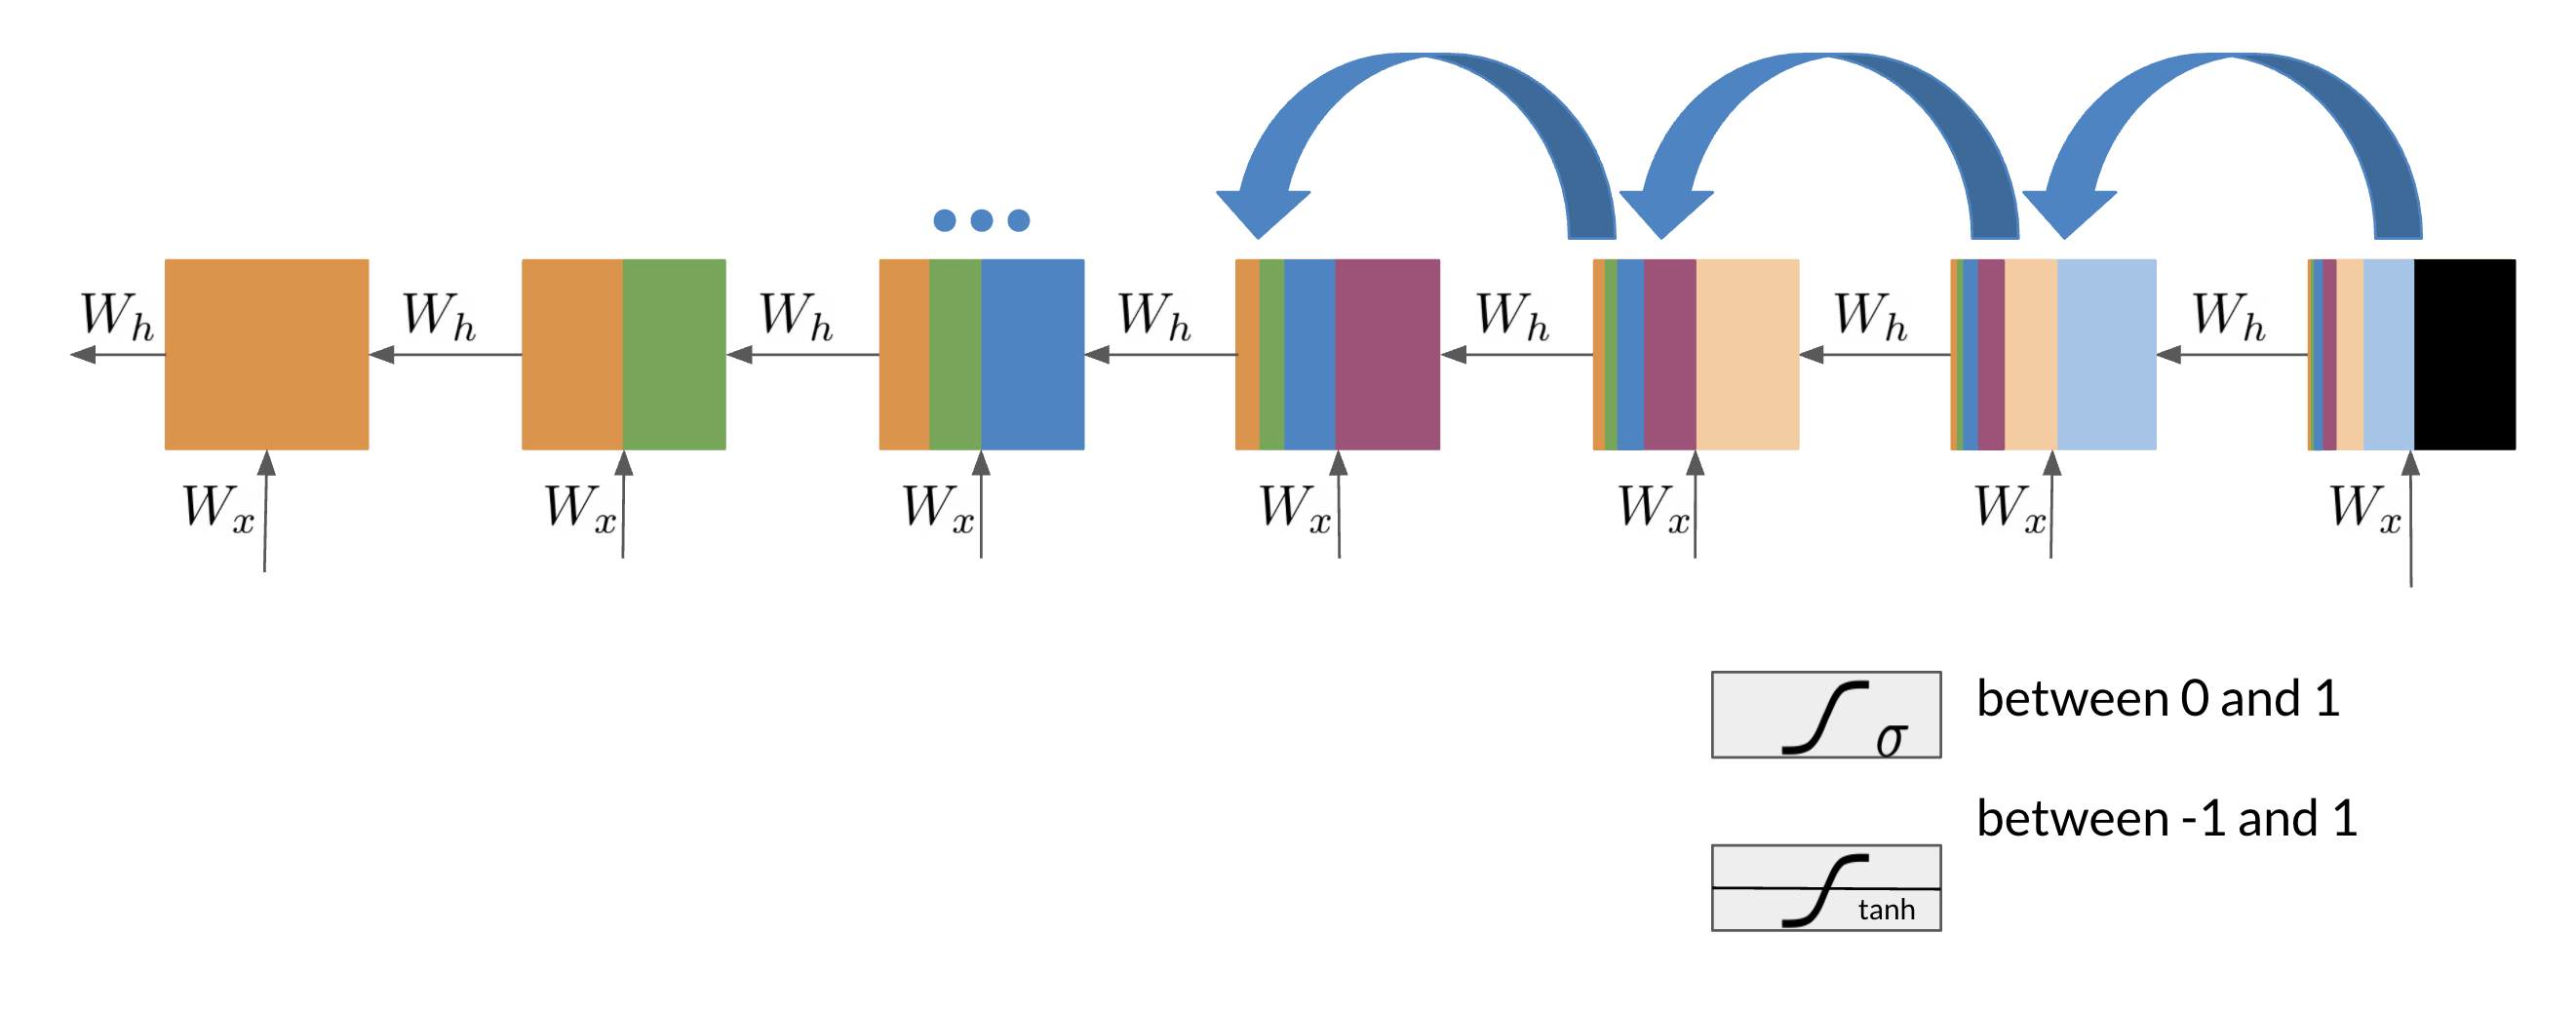

Note that the sigmoid and tanh functions are bounded by 0 and 1 and -1 and 1 respectively. This eventually leads us to a problem. If you have many numbers that are less than |1|, then as you go through many layers, and you take the product of those numbers, you eventually end up getting a gradient that is very close to 0. This introduces the problem of vanishing gradients. 

#### The possible solution to Vanishing Gradient Problems:

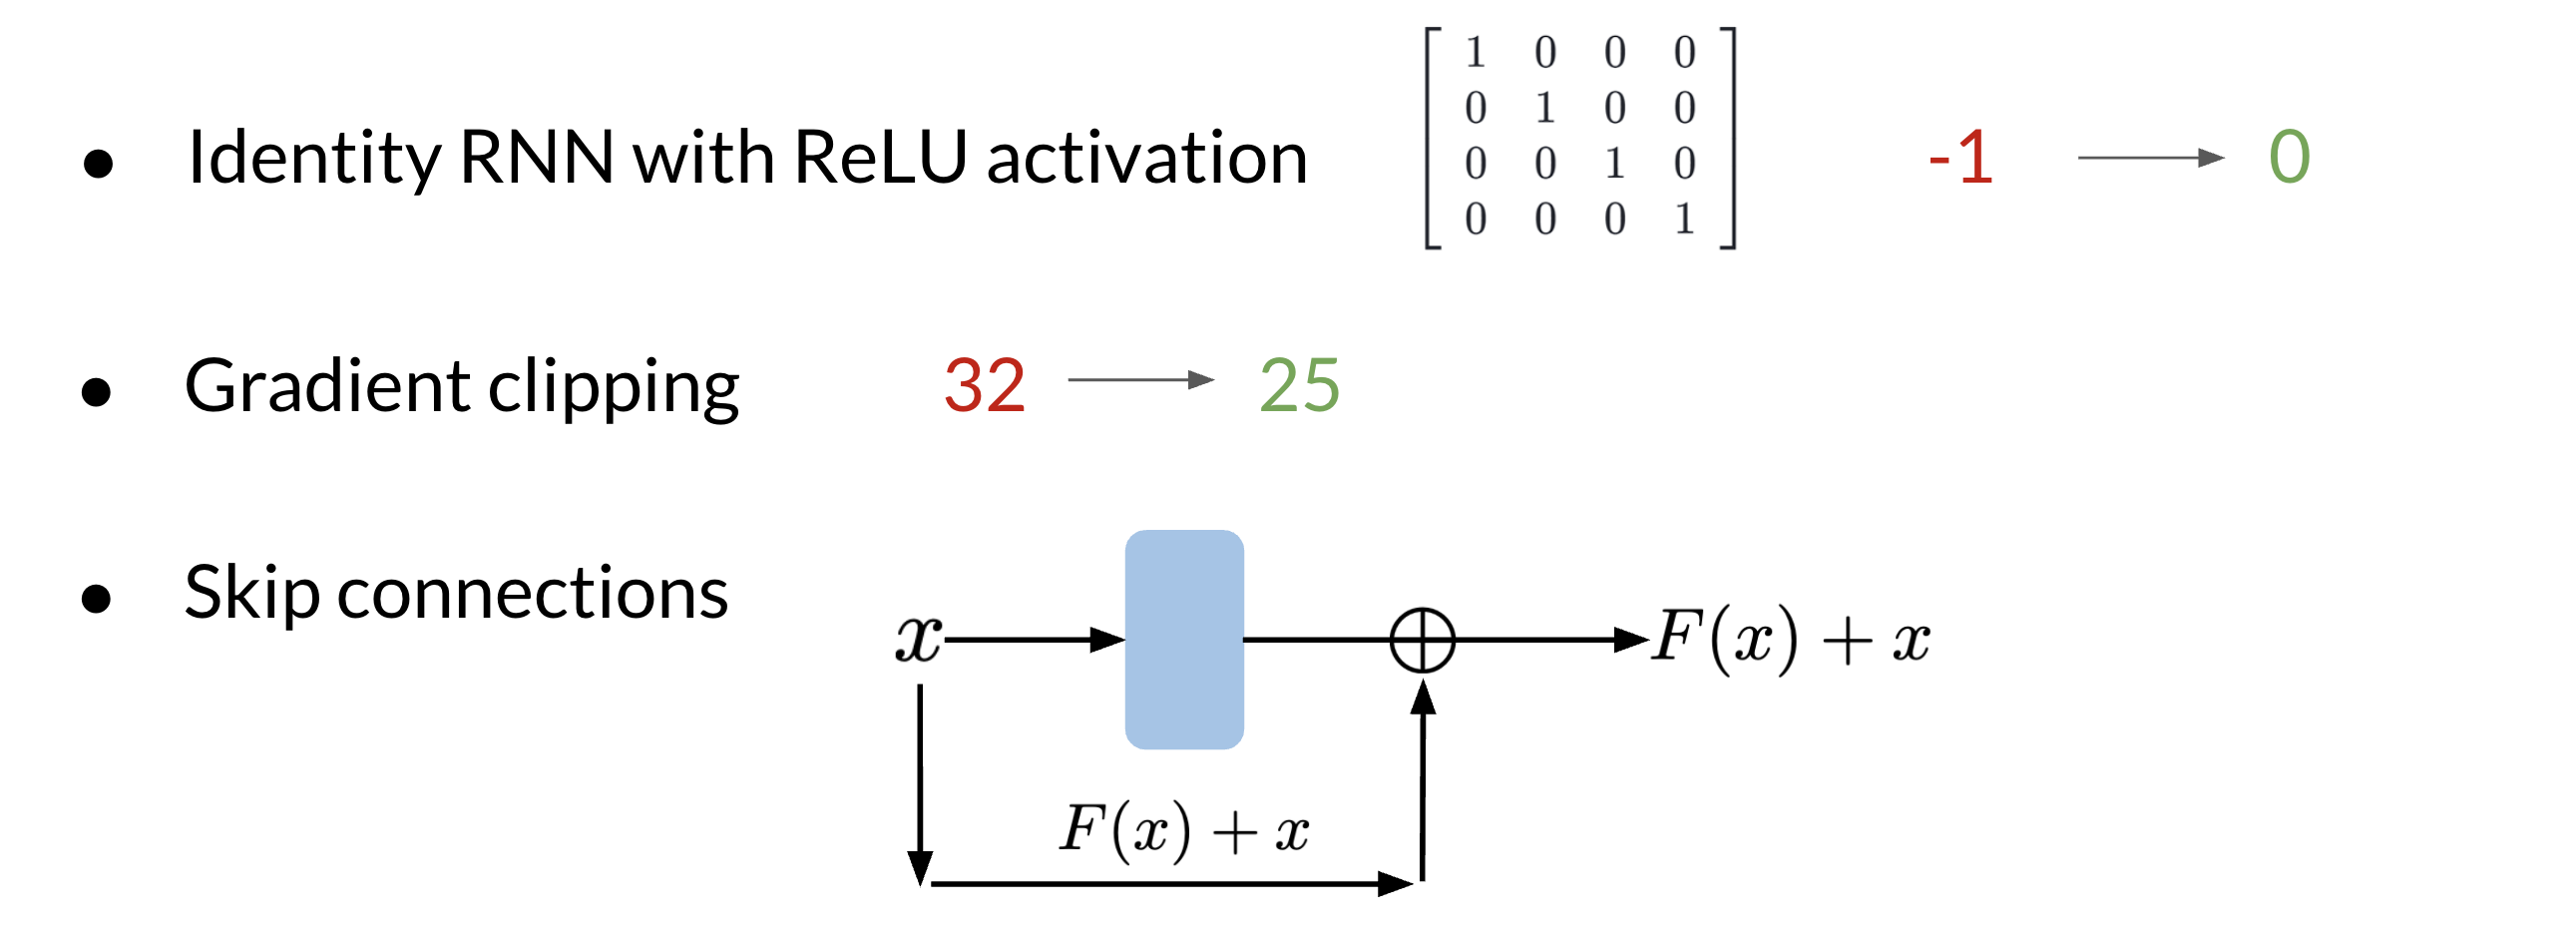

The LSTM allows your model to remember and forget certain inputs. It consists of a cell state and a hidden state with three gates. The gates allow the gradients to flow unchanged. You can think of the three gates as follows: 

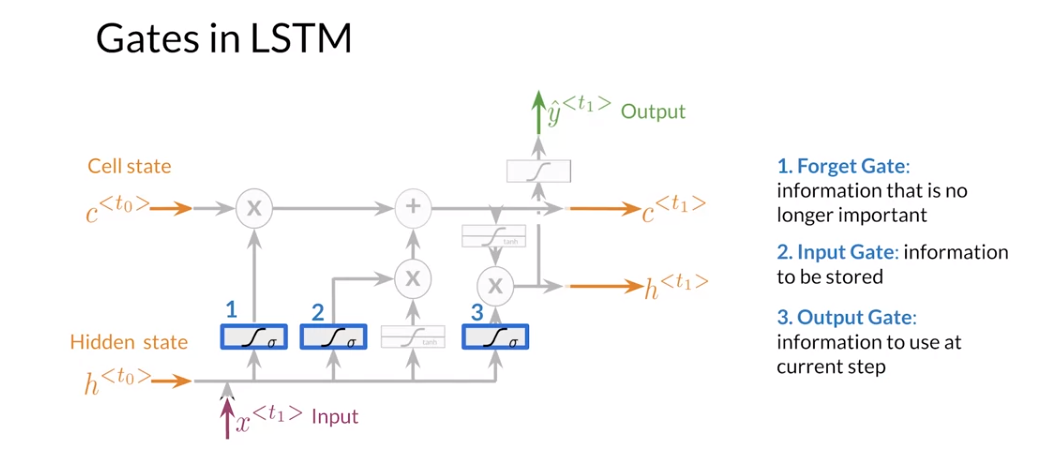

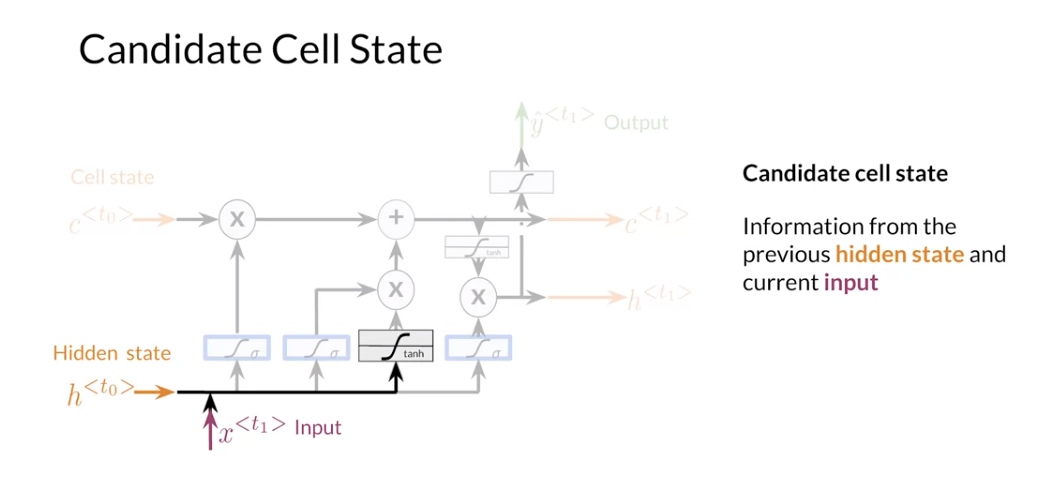

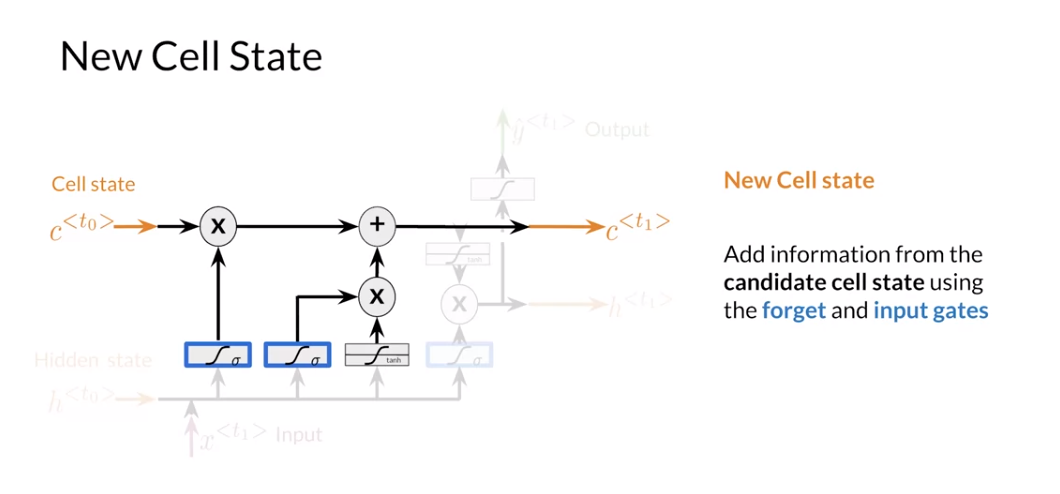

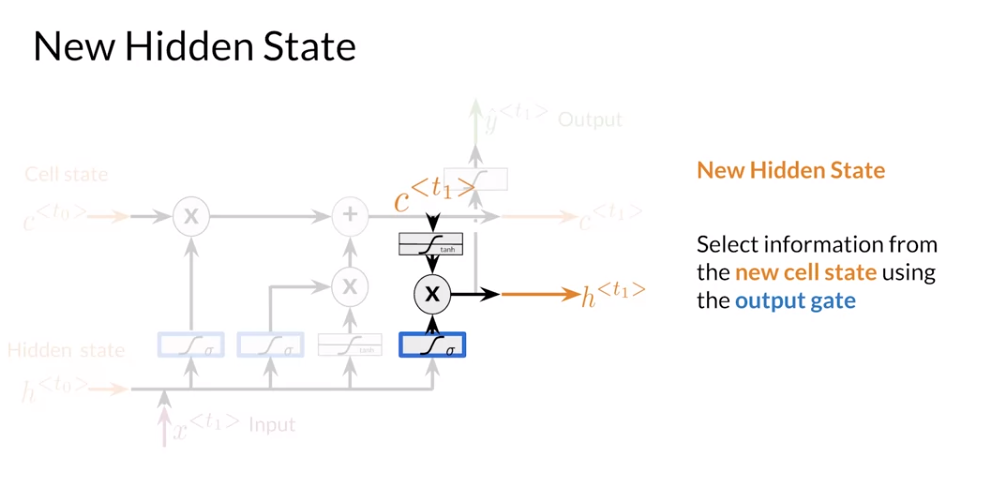

#### LSTM application:

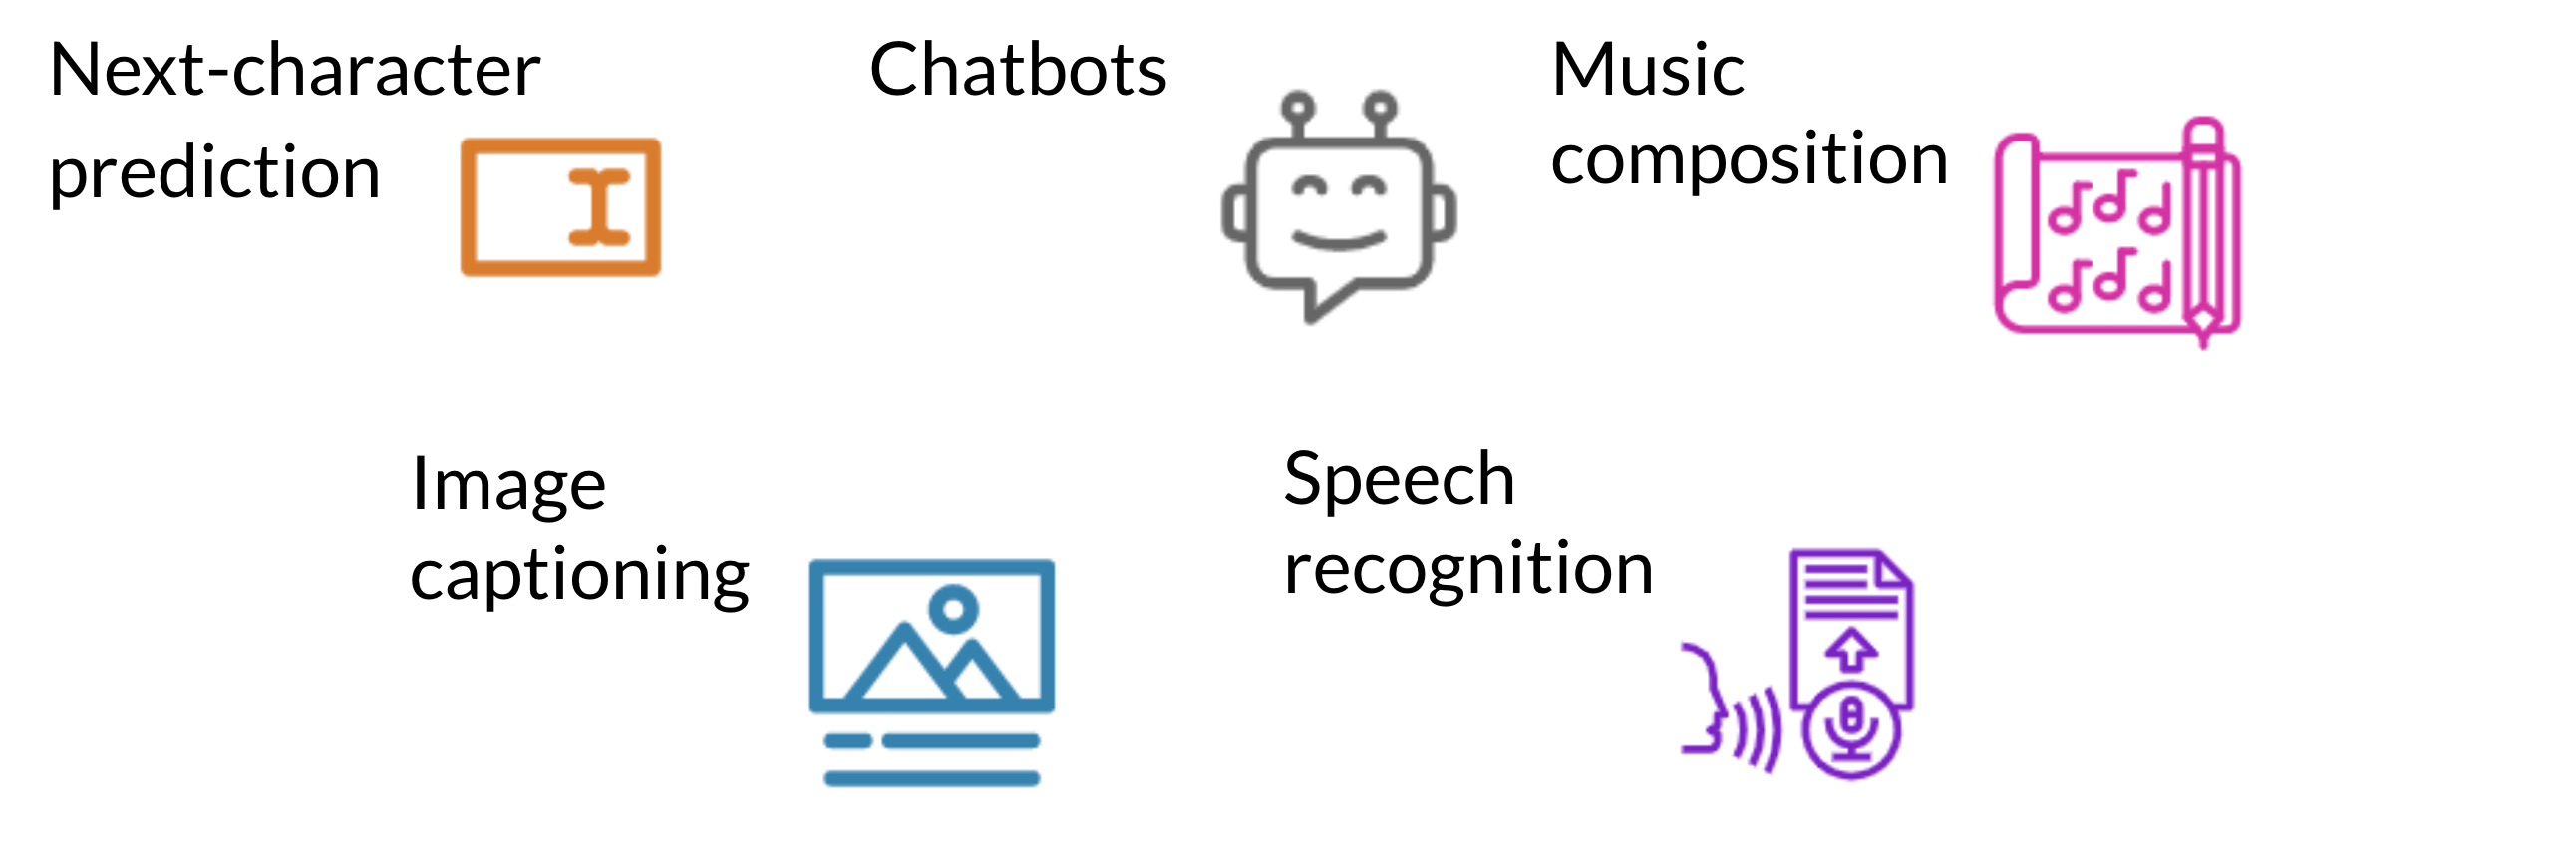

# NER with LSTM (implementation)

## Encodding

In [ ]:
# get_sentence_vectorizer
def get_sentence_vectorizer(sentences):
    tf.keras.utils.set_random_seed(33) 
    """
    Create a TextVectorization layer for sentence tokenization and adapt it to the provided sentences.

    Parameters:
    sentences (list of str): Sentences for vocabulary adaptation.

    Returns:
    sentence_vectorizer (tf.keras.layers.TextVectorization): TextVectorization layer for sentence tokenization.
    vocab (list of str): Extracted vocabulary.
    """
    # Define TextVectorization object with the appropriate standardize parameter
    sentence_vectorizer = tf.keras.layers.TextVectorization(standardize=None) #'lower_and_strip_punctuation')
    # Adapt the sentence vectorization object to the given sentences
    sentence_vectorizer.adapt(sentences)
    # Get the vocabulary
    vocab = sentence_vectorizer.get_vocabulary()    
    return sentence_vectorizer, vocab

In [ ]:
def get_tags(labels):
    tag_set = set() # Define an empty set
    for el in labels:
        for tag in el.split(" "):
            tag_set.add(tag)
    tag_list = list(tag_set) 
    tag_list.sort()
    return tag_list

In [ ]:
def make_tag_map(tags):
    tag_map = {}
    for i,tag in enumerate(tags):
        tag_map[tag] = i 
    return tag_map

In [ ]:
# label_vectorizer
def label_vectorizer(labels, tag_map):
    """
    Convert list of label strings to padded label IDs using a tag mapping.

    Parameters:
    labels (list of str): List of label strings.
    tag_map (dict): Dictionary mapping tags to IDs.
    Returns:
    label_ids (numpy.ndarray): Padded array of label IDs.
    """
    label_ids = [] # It can't be a numpy array yet, since each sentence has a different size

    # Each element in labels is a string of tags so for each of them:
    for element in labels:
        # Split it into single tokens. You may use .split function for strings. Be aware to split it by a blank space!
        tokens = element.split(' ')

        # Use the dictionaty tag_map passed as an argument to the label_vectorizer function
        # to make the correspondence between tags and numbers. 
        element_ids = []

        for token in tokens:
            element_ids.append(tag_map[token])

        # Append the found ids to corresponding to the current element to label_ids list
        label_ids.append(element_ids)
        
    # Pad the elements
    label_ids = tf.keras.utils.pad_sequences(label_ids, padding='post', value=-1)

    return label_ids

## Building the dataset

In [ ]:
def generate_dataset(sentences, labels, sentence_vectorizer, tag_map):
    sentences_ids = sentence_vectorizer(sentences)
    labels_ids = label_vectorizer(labels, tag_map = tag_map)
    dataset = tf.data.Dataset.from_tensor_slices((sentences_ids, labels_ids))
    return dataset

## Building the model

In [ ]:
# NER
def NER(len_tags, vocab_size, embedding_dim = 50):
    """
    Create a Named Entity Recognition (NER) model.

    Parameters:
    len_tags (int): Number of NER tags (output classes).
    vocab_size (int): Vocabulary size.
    embedding_dim (int, optional): Dimension of embedding and LSTM layers (default is 50).

    Returns:
    model (Sequential): NER model.
    """

    model = tf.keras.Sequential(name = 'sequential') 
    # Add the tf.keras.layers.Embedding layer. Do not forget to mask out the zeros!
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, mask_zero=True))
    # Add the LSTM layer. Make sure you are passing the right dimension (defined in the docstring above) 
    # and returning every output for the tf.keras.layers.LSTM layer and not the very last one.
    model.add(tf.keras.layers.LSTM(units=embedding_dim, return_sequences=True))
    # Add the final tf.keras.layers.Dense with the appropriate activation function. Remember you must pass the activation function itself ant not its call!
    # You must use tf.nn.log_softmax instead of tf.nn.log_softmax().
    model.add(tf.keras.layers.Dense(units=len_tags, activation=tf.nn.log_softmax))

    return model

In [ ]:
# masked_loss
def masked_loss(y_true, y_pred):
    """
    Calculate the masked sparse categorical cross-entropy loss.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.
    
    Returns:
    loss (tensor): Calculated loss.
    """
    
    # Calculate the loss for each item in the batch. Remember to pass the right arguments, as discussed above!
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=-1)
    # Use the previous defined function to compute the loss
    loss = loss_fn(y_true, y_pred)
    
    return  loss 

In [ ]:
# masked_accuracy
def masked_accuracy(y_true, y_pred):
    """
    Calculate masked accuracy for predicted labels.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    accuracy (tensor): Masked accuracy.

    """
    
    # Calculate the loss for each item in the batch.
    # You must always cast the tensors to the same type in order to use them in training. Since you will make divisions, it is safe to use tf.float32 data type.
    y_true = tf.cast(y_true, tf.float32) 
    # Create the mask, i.e., the values that will be ignored
    mask = masked_loss(y_true, y_pred)
    mask = tf.cast(mask, tf.float32) 
    # Perform argmax to get the predicted values
    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    y_pred_class = tf.cast(y_pred_class, tf.float32) 
    # Compare the true values with the predicted ones
    matches_true_pred  = tf.equal(y_true, y_pred_class)
    matches_true_pred = tf.cast(matches_true_pred , tf.float32) 
    # Multiply the acc tensor with the masks
    matches_true_pred *= mask
    # Compute masked accuracy (quotient between the total matches and the total valid values, i.e., the amount of non-masked values)
    masked_acc = tf.reduce_sum(mask) / tf.reduce_sum(matches_true_pred)

    return masked_acc

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), 
              loss = masked_loss,
               metrics = [masked_accuracy])

In [ ]:
tf.keras.utils.set_random_seed(33) ## Setting again a random seed to ensure reproducibility

BATCH_SIZE = 64

model.fit(train_dataset.batch(BATCH_SIZE),
          validation_data = val_dataset.batch(BATCH_SIZE),
          shuffle=True,
          epochs = 2)

## Compute Accuracy

In [ ]:
# Convert the sentences into ids
test_sentences_id = sentence_vectorizer(test_sentences)
# Convert the labels into token ids
test_labels_id = label_vectorizer(test_labels,tag_map)
# Rename to prettify next function call
y_true = test_labels_id 
y_pred = model.predict(test_sentences_id)

## Test model

In [ ]:
# predict
def predict(sentence, model, sentence_vectorizer, tag_map):
    """
    Predict NER labels for a given sentence using a trained model.

    Parameters:
    sentence (str): Input sentence.
    model (tf.keras.Model): Trained NER model.
    sentence_vectorizer (tf.keras.layers.TextVectorization): Sentence vectorization layer.
    tag_map (dict): Dictionary mapping tag IDs to labels.

    Returns:
    predictions (list): Predicted NER labels for the sentence.

    """

    # Convert the sentence into ids
    sentence_vectorized = sentence_vectorizer(sentence)
    # Expand its dimension to make it appropriate to pass to the model
    sentence_vectorized = tf.expand_dims(sentence_vectorized, axis=0)
    # Get the model output
    output = model.predict(sentence_vectorized)
    # Get the predicted labels for each token, using argmax function and specifying the correct axis to perform the argmax
    outputs = np.argmax(output, axis = -1)
    # Next line is just to adjust outputs dimension. Since this function expects only one input to get a prediction, outputs will be something like [[1,2,3]]
    # so to avoid heavy notation below, let's transform it into [1,2,3]
    outputs = outputs[0] 
    # Get a list of all keys, remember that the tag_map was built in a way that each label id matches its index in a list
    labels = list(tag_map.keys()) 
    pred = [] 
    # Iterating over every predicted token in outputs list
    for tag_idx in outputs:
        pred_label = labels[tag_idx]
        pred.append(pred_label)
    
    return pred

In [ ]:
# Try the output for the introduction example
#sentence = "Many French citizens are goin to visit Morocco for summer"
#sentence = "Sharon Floyd flew to Miami last Friday"

# New york times news:
sentence = "Peter Parker , the White House director of trade and manufacturing policy of U.S , said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall , though he said it wouldn ’t necessarily come"
predictions = predict(sentence, model, sentence_vectorizer, tag_map)
for x,y in zip(sentence.split(' '), predictions):
    if y != 'O':
        print(x,y)

# Siamese Networks

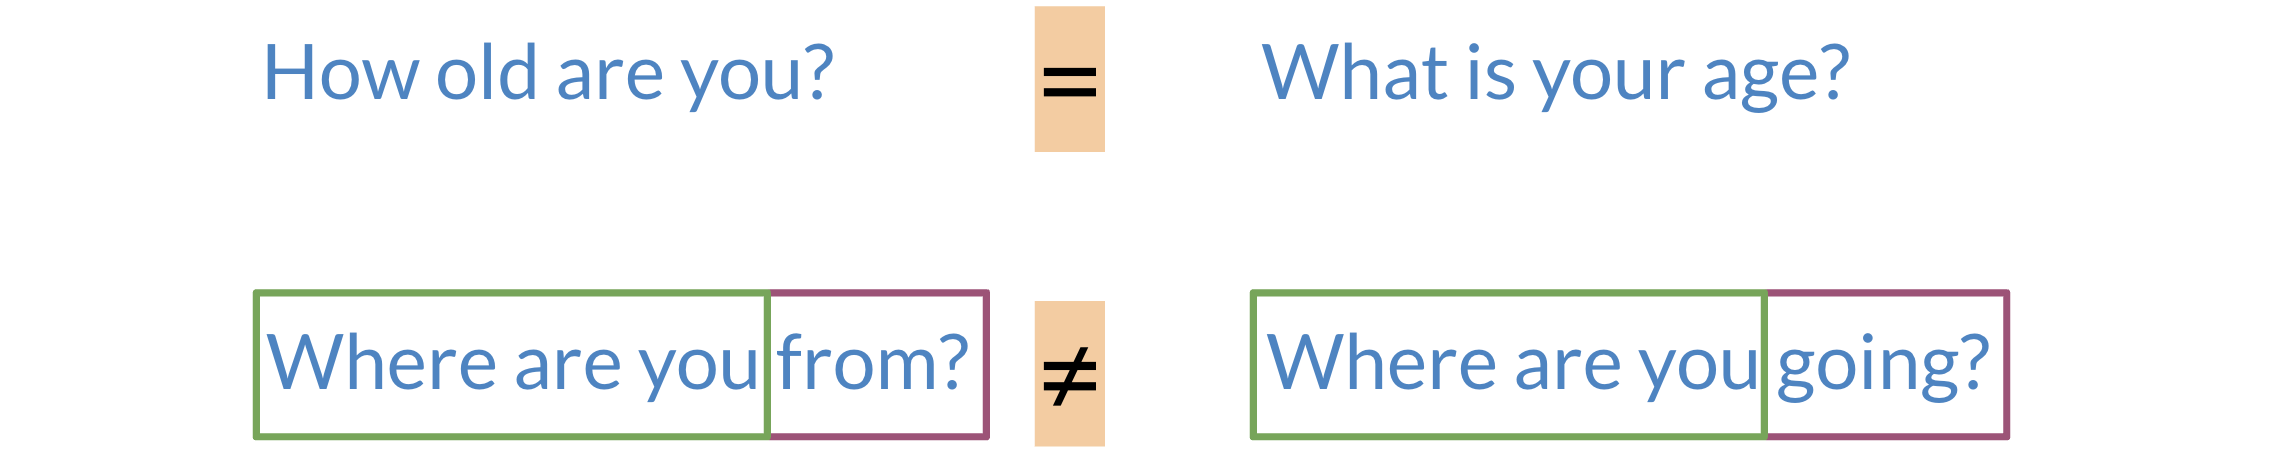

The first example above, the two sentences mean the same thing but have completely different words. While in the second case, the two sentences mean completely different things but they have very similar words. 

Classification: learns what makes an input what it is.

Siamese Networks: learns what makes two inputs the same

Here are a few applications of siamese networks: 
* Handwritten checks 
* Question duplicates
* Queries

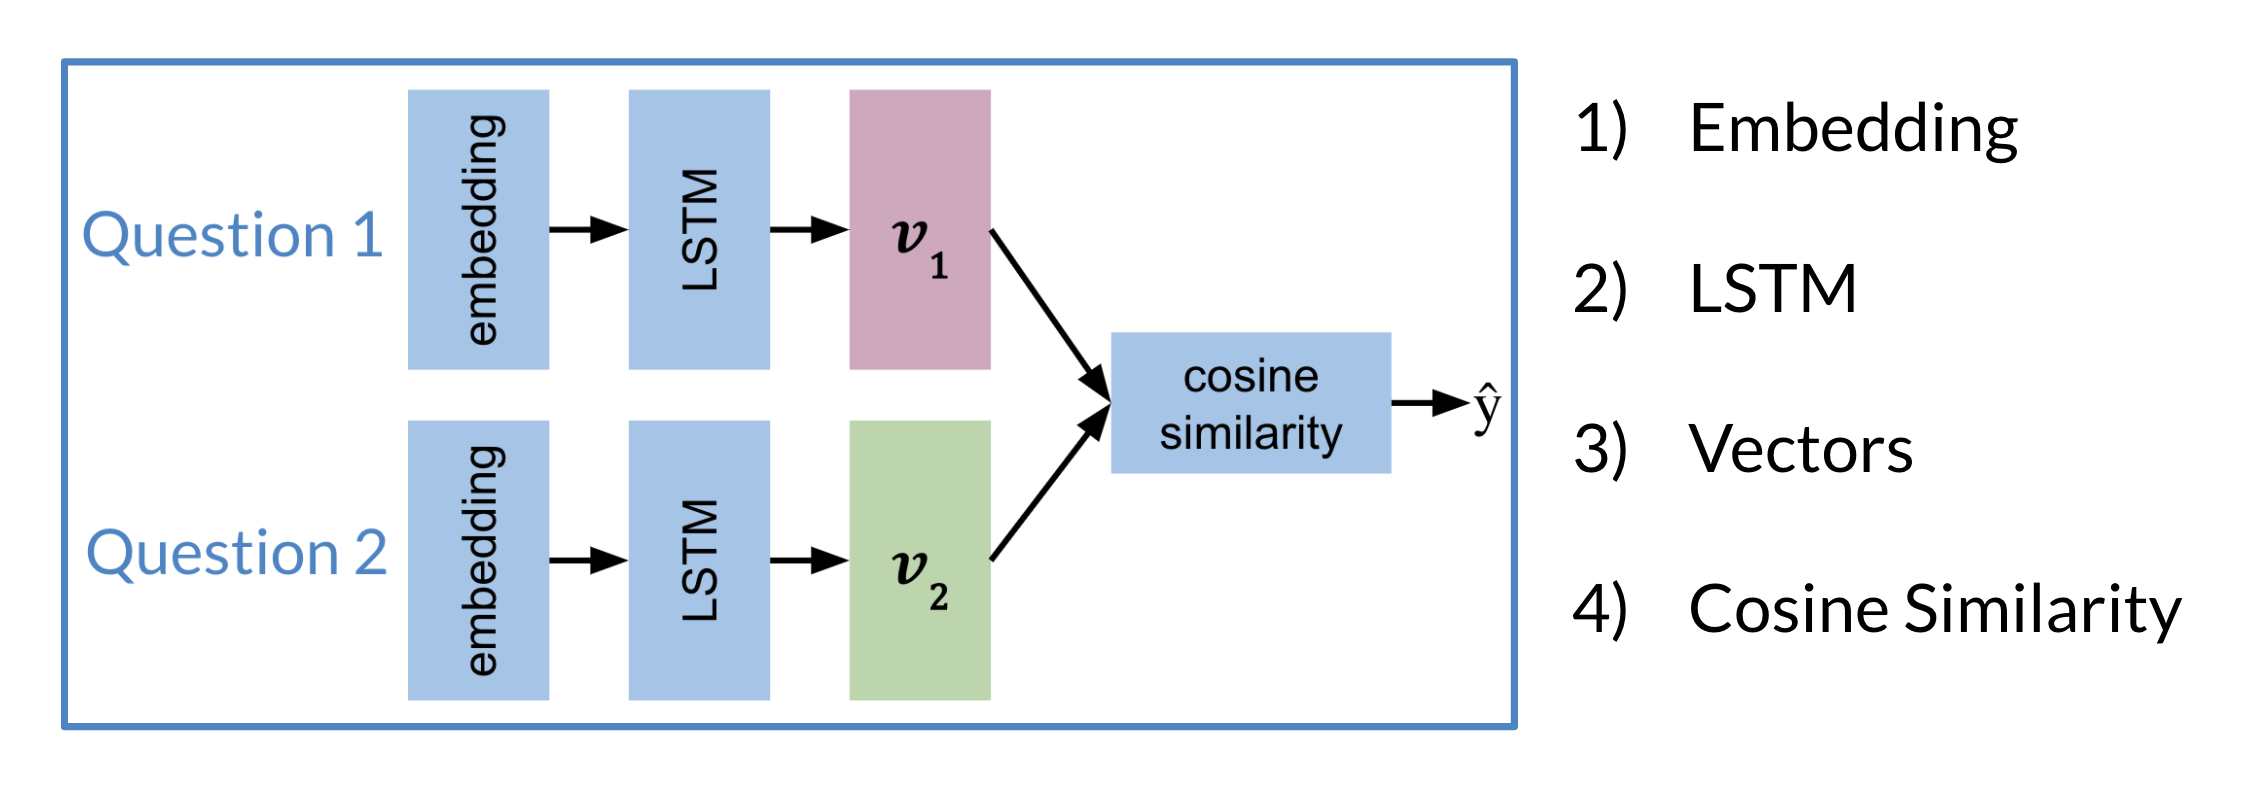

* Not all Siamese networks will be designed to contain LSTMs. 
* One thing to remember is that sub-networks share identical parameters. This means that you only need to train one set of weights and not two. 
* The output of each sub-network is a vector. You can then run the output through a cosine similarity function to get the similarity score. 

In [ ]:
# Siamese Network architecture

vocab_size = 500
model_dimension = 128

# Define the LSTM model
LSTM = Sequential()
LSTM.add(layers.Embedding(input_dim=vocab_size, output_dim=model_dimension))
LSTM.add(layers.LSTM(units=model_dimension, return_sequences = True))
LSTM.add(layers.AveragePooling1D())
LSTM.add(layers.Lambda(lambda x: math.l2_normalize(x)))

input1 = layers.Input((None,))
input2 = layers.Input((None,))

# Concatenate two LSTMs together
conc = layers.Concatenate(axis=1)((LSTM(input1), LSTM(input2)))
    

# Use the Parallel combinator to create a Siamese model out of the LSTM 
Siamese = Model(inputs=(input1, input2), outputs=conc)

# Print the summary of the model
Siamese.summary()

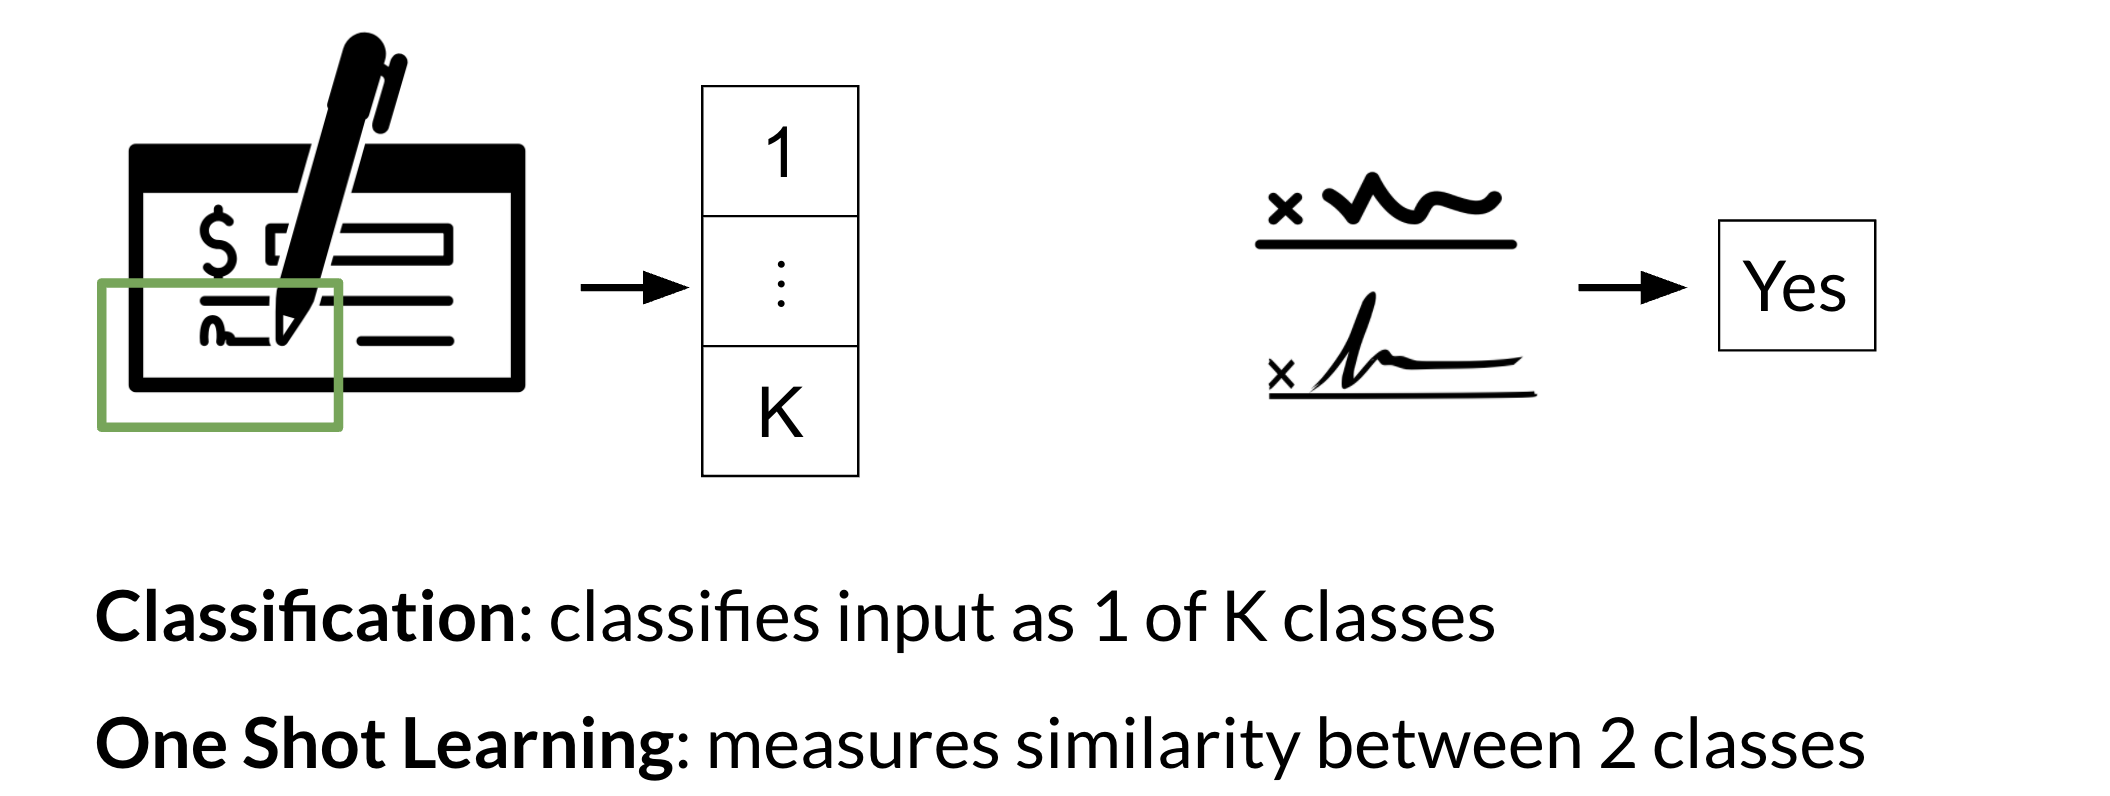

Hence, we resort to one shot learning. Instead of retraining your model for every signature, you can just learn a similarity score as follows: 

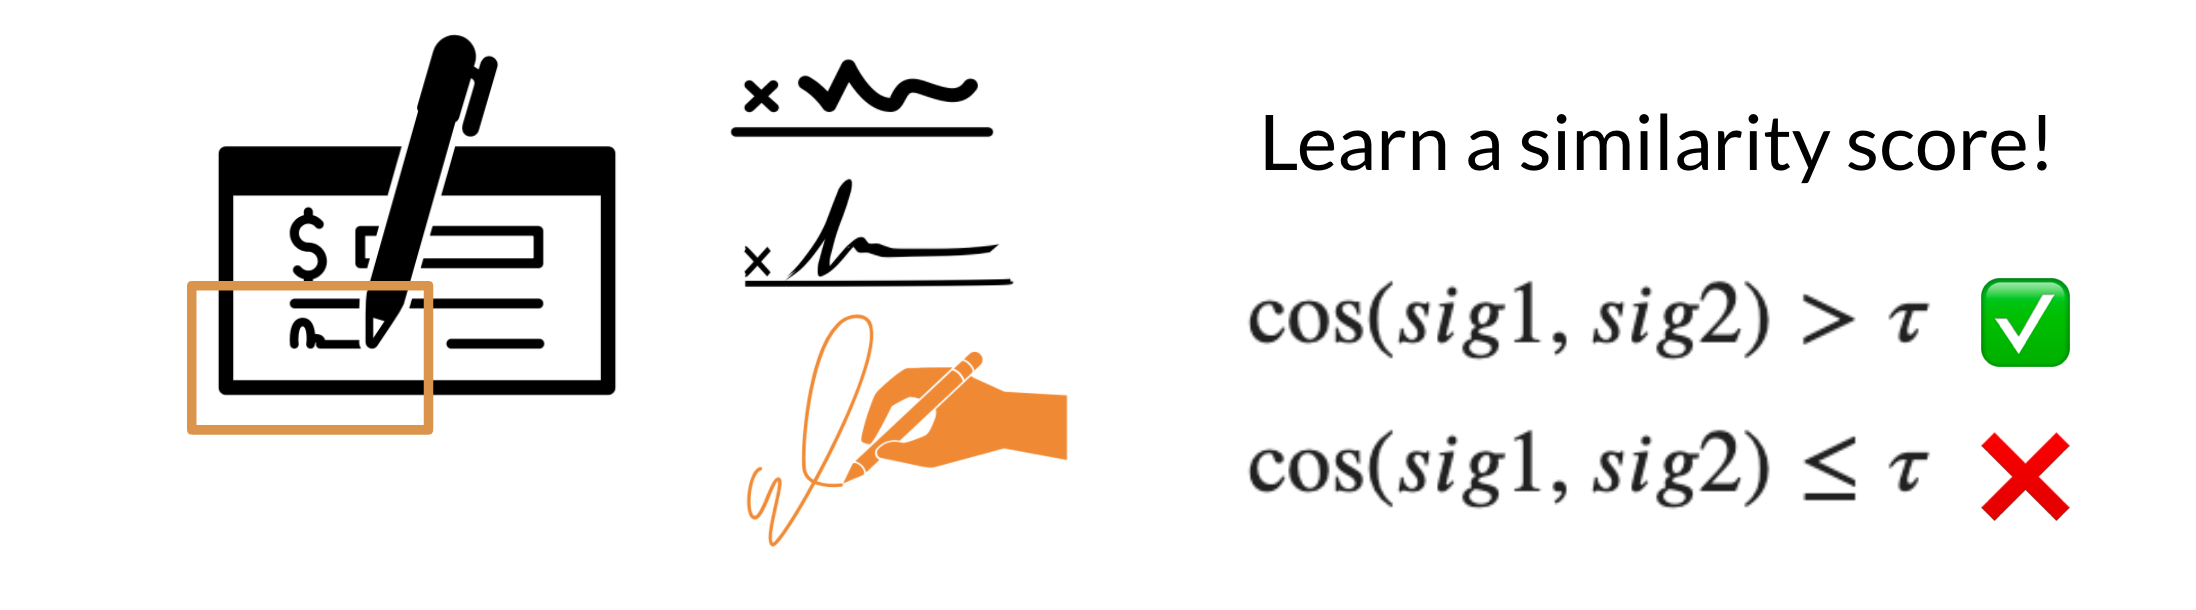

# Siamese Networks (implementation)

In [ ]:
# TBD